In [1]:
#Astropy
import astropy
from astropy.io import fits
from astropy.table import Table

# Matplotlib
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline
matplotlib.rcParams.update({'font.size': 25})

#Numpy/Scipy
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
from scipy.optimize import curve_fit

class Aetas():
    '''
    A class to calculate a star's age and extinction using PARSEC isochrones and extinction law
    from Cardelli et al. 1989 by fitting Gaia (BP, RP) and 2MASS (J,H,K) photometry
    '''
    def __init__(self,teff,abund,obsphot,distance,isochrones,rv=3.1):
        
        '''
        teff: [array] Teff and error of star np.array([teff,teff_err])
        abund: [2x1 array] first column is [M/H],[Alpha/M]
        obs_phot: [5x2 array] first column is GBP,GRP,J,H,K and the second column is the errors in the first 
        distance: [float] distance to star in pc
        isochrones: [astropy Table] PARSEC isochrone table
        rv: [float] Rv value (=Av/E(B_V)) 
        '''
        
        # Observed Quantities
        self.teff = teff[0] # temperature
        self.teff_err = teff[1] # temperature error
        self.salfeh = abund[0,0]+np.log10(0.655*(10**(abund[1,0]))+0.345) # Salaris Corrected [Fe/H]
        self.salfeh_err = np.sqrt(abund[0,1]**2+((1-0.345/(0.655*(10**(abund[1,0]))+0.345))*abund[1,1])**2)
        self.phot = obsphot[:,0] # photometry
        self.phot_err = obsphot[:,1] # photometry errors
        
        # Distance modulus
        self.distance = distance
        self.distmod = 5.0*np.log10(distance)-5.0
        
        # PARSEC isochrones
        self.rv = rv
        self.labels = ['G_BPmag','G_RPmag','Jmag','Hmag','Ksmag']
        
#         self.uniq_ages = np.unique(isochrones['logAge'])
        self.iso = isochrones[np.where(isochrones['MH']==self.closest(isochrones['MH'],self.salfeh))]
        self.uniq_ages = np.unique(self.iso['logAge'])
        
        age_idx = []
        for i in range(len(self.uniq_ages)):
            ages, = np.where(self.iso['logAge']==self.uniq_ages[i])
            age_idx.append(np.array([min(ages),max(ages)]))
        
        self.age_idx = np.asarray(age_idx)
                
        # Effective Wavelengths of different passbands in units of microns
        self.leff = {'G_BPmag':0.5387,'Gmag':0.6419,'G_RPmag':0.7667,'Jmag':1.2345,'Hmag':1.6393,'Ksmag':2.1757}
        
    #################
    ### Utilities ###
    #################
        
    def closest(self,data,value):
        '''
        Find nearest value in array to given value
        
        Inputs:
        ------
            data: data to search through 
            value: value of interest
        '''
        
        data = np.asarray(data)
    
        return data[(np.abs(np.subtract(data,value))).argmin()]
    
    def neighbors(self,data,value):
        '''
        Find values of two elements closest to the given value
    
        Inputs:
        ------
            data: data to search through 
            value: value of interest
        
        Output:
        ------
            close1: closest value under the given value
            close2: closest value over the given value
        '''
    
        data = np.asarray(data)
        close1 = data[(np.abs(np.subtract(data,value))).argmin()]
        data = data[np.where(data!=close1)]
        close2 = data[(np.abs(np.subtract(data,value))).argmin()]
    
        return close1,close2
    
    def mad(self,data):
        '''
        Calculate the median absolute deviation of the data
        '''
        return np.nanmedian(np.abs(data-np.nanmedian(data)))
    
    ##################
    ### Extinction ###
    ##################
    
    def ccm_a(self,x):
        '''
        a(x) function from ccm et al. 1989
    
        Input:
        -----
            x: effective wavelength in units of 1/micron
        
        Output:
        ------
            a: a function value  
        '''
        if 0.3 <= x < 1.1:
            a = 0.574*(x**1.61)
            return a
    
        elif 1.1 <= x < 3.3:
            y = x - 1.82
            a = (1.+0.17699*y-0.50477*(y**2)-0.02427*(y**3)+0.72085*(y**4)+
                 0.01979*(y**5)-0.77530*(y**6)+0.32999*(y**7))
            return a
    
        elif 3.3 <= x < 8.0:
            if x < 5.9:
                a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)
                return a
        
            else:
                fa = -0.04473*((x-5.9)**2)+0.1207*((x-5.9)**3)
                a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)+fa
                return a       
    
    def ccm_b(self,x):
        '''
        b(x) function from ccm et al. 1989
    
        Input:
        -----
            x: effective wavelength in units of 1/micron
        
        Output:
        ------
            b: b function value 
        '''
        if 0.3 <= x < 1.1:
            b = -0.527*(x**1.61)
            return b
    
        elif 1.1 <= x <= 3.3:
            y = x - 1.82
            b = (1.41338*y+2.28305*(y**2)+1.07233*(y**3)-5.38434*(y**4)-
                 0.62251*(y**5)+5.30260*(y**6)-2.09002*(y**7))
            return b
    
        elif 3.3 <= x < 8.0:
            if x < 5.9:
                b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)
                return b
        
            else:
                fb = 0.2130*((x-5.9)**2)+0.1207*((x-5.9)**3)
                b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)+fb
                return b
    
    def ccm_alav(self,wave):
        '''
        Calculate A\lambda/Av
    
        Inputs:
        ------
            wave: effective wavelength in units of micron
        
        Output:
        ------
            alav: A\lambda/Av
        '''
        x=1/wave
        alav = self.ccm_a(x)+self.ccm_b(x)/self.rv
        return alav
    
    def extinction(self):
        '''
        Calculate the K band extinction and its uncertainty
        '''

        ### Reddening to K band extinctions based on Cardelli et al.
        ebpk_k = ((self.ccm_alav(self.leff['G_BPmag'])-self.ccm_alav(self.leff['Ksmag']))/
                  self.ccm_alav(self.leff['Ksmag']))
        erpk_k = ((self.ccm_alav(self.leff['G_RPmag'])-self.ccm_alav(self.leff['Ksmag']))/
                  self.ccm_alav(self.leff['Ksmag']))
        ejk_k = ((self.ccm_alav(self.leff['Jmag'])-self.ccm_alav(self.leff['Ksmag']))/
                 self.ccm_alav(self.leff['Ksmag']))
        ehk_k = ((self.ccm_alav(self.leff['Hmag'])-self.ccm_alav(self.leff['Ksmag']))/
                 self.ccm_alav(self.leff['Ksmag']))

        e_k = np.array([ebpk_k,erpk_k,ejk_k,ehk_k])

        ### Spline 
        # pick isochrone points with temperatures within 100 K of the star's Teff
        teffcut = np.where((self.iso['logTe']<np.log10(self.teff+100.))&
                           (self.iso['logTe']>np.log10(self.teff-100.)))
        iso_ = self.iso[teffcut]

        # sort teffs
        sidx = np.argsort(iso_['logTe'])
        slogTe = iso_['logTe'][sidx]
        _, uidx = np.unique(slogTe,return_index=True)
        slogTe = slogTe[uidx]

        calc_aks = 999999.0*np.ones(4)
        calc_aks_err = 999999.0*np.ones(4)

        coeff0s = 999999.0*np.ones(4)
        for i in range(4):
            try:
                coeff = np.polyfit(10**slogTe,(iso_[self.labels[i]]-iso_['Ksmag'])[sidx][uidx],1)
                color_line = np.poly1d(coeff)
                calc_aks[i] = np.divide((self.phot[i]-self.phot[-1])-color_line(self.teff),e_k[i])
                coeff0s[i] = coeff[0]

            except:
                calc_aks[i] = 999999.0 
                calc_aks_err[i] = 999999.0

        calc_aks_err = np.sqrt(np.divide(np.square(self.phot_err[:-1])+
                                         np.square(np.multiply(coeff0s,self.teff_err)),np.square(e_k)))

        ### Weighted Mean
        wgts = np.square(np.reciprocal(calc_aks_err))
        wgts_sum = np.sum(wgts)

        ak = np.sum(np.multiply(calc_aks,wgts))/wgts_sum
        ak_err = np.sqrt(np.reciprocal(wgts_sum))
        
        self.ak = ak
        self.ak_err = ak_err
        
        return ak, ak_err
    
    def teff_2_appmags(self,teff,age):
        '''
        Calculate the expected apparent magnitudes of a star in the BP, RP, J, H, and K bands
        
        Input:
        -----
            teff: Teff of a star
            age: age of a star
            
        Output:
        ------
            calc_mags: calculated absolute magnitude
        '''
        
        ### Setup Calculations
        # extinctions
        abpak = (self.ccm_alav(self.leff['G_BPmag'])/self.ccm_alav(self.leff['Ksmag']))
        arpak = (self.ccm_alav(self.leff['G_RPmag'])/self.ccm_alav(self.leff['Ksmag']))
        ajak = (self.ccm_alav(self.leff['Jmag'])/self.ccm_alav(self.leff['Ksmag']))
        ahak = (self.ccm_alav(self.leff['Hmag'])/self.ccm_alav(self.leff['Ksmag']))
        
        aks = np.array([abpak,arpak,ajak,ahak,1.0])*self.ak
        
        # log values
        lgteff = np.log10(teff)
        lgage = np.log10(age*10**9)
        
        ### Check if age is in table
        if lgage in self.uniq_ages:
            
            # pick isochrone and only keep points close in Teff 
            aidx, = np.where(self.uniq_ages==lgage)
            iso_ = self.iso[self.age_idx[int(aidx)][0]:self.age_idx[int(aidx)][1]]
            iso_ = iso_[np.where((iso_['logTe']<np.log10(teff+100.))&(iso_['logTe']>np.log10(teff-100.)))]
            
            # check if there are enough points
            if np.size(iso_) < 2:
                return np.array([999999.0,999999.0,999999.0,999999.0,999999.0])
            
            # sort Teff values
            sidx = np.argsort(iso_['logTe'])
            slogTe = iso_['logTe'][sidx]
            _, uidx = np.unique(slogTe,return_index=True)
            slogTe = slogTe[uidx]
            
            # calculate the apparent magnitudes
            calc_mags = 999999.0*np.ones(5)
            for i in range(len(calc_mags)):
                interpol = np.poly1d(np.polyfit(slogTe,iso_[self.labels[i]][sidx][uidx],1))
                calc_mags[i] = interpol(teff)+self.distmod+aks[i]
                
            return calc_mags
            
        else:
            # find closest two ages to the given age
            lgage_lo, lgage_hi = self.neighbors(self.uniq_ages,lgage)
            
            # lower age
            # pick isochrone and only keep points close in Teff
            aidx_lo, = np.where(self.uniq_ages==lgage_lo)
            iso_lo = self.iso[self.age_idx[int(aidx_lo)][0]:self.age_idx[int(aidx_lo)][1]]
            iso_lo = iso_lo[np.where((iso_lo['logTe']<np.log10(teff+100.))&
                                     (iso_lo['logTe']>np.log10(teff-100.)))]
            
            # sort Teff values
            sidx_lo = np.argsort(iso_lo['logTe'])
            slogTe_lo = iso_lo['logTe'][sidx_lo]
            _, uidx_lo = np.unique(slogTe_lo,return_index=True)
            slogTe_lo = slogTe_lo[uidx_lo]
            
            # higher age
            # pick isochrone and only keep points close in Teff
            aidx_hi, = np.where(self.uniq_ages==lgage_hi)
            iso_hi = self.iso[self.age_idx[int(aidx_hi)][0]:self.age_idx[int(aidx_hi)][1]]
            iso_hi = iso_lo[np.where((iso_hi['logTe']<np.log10(teff+100.))&
                                     (iso_hi['logTe']>np.log10(teff-100.)))]
            
            # check if there are enough points
            if (np.size(iso_lo) < 2) or (np.size_hi < 2):
                return np.array([999999.0,999999.0,999999.0,999999.0,999999.0])
            
            # sort Teff values
            sidx_hi = np.argsort(iso_hi['logTe'])
            slogTe_hi = iso_hi['logTe'][sidx_hi]
            _, uidx_hi = np.unique(slogTe_hi,return_index=True)
            slogTe_hi = slogTe_hi[uidx_hi]
            
            # calculate the apparent magnitudes
            calc_mags = 999999.0*np.ones(5)
            for i in range(len(calc_mags)):
                interpol_lo = np.poly1d(np.polyfit(slogTe_lo,iso_lo[self.labels[i]][sidx][uidx],1))
                interpol_hi = np.poly1d(np.polyfit(slogTe_hi,iso_hi[self.labels[i]][sidx][uidx],1))
                interpol_age = np.poly1d(np.polyfit([lgage_lo,lgage_hi],
                                                    [interpol_lo(teff),interpol_hi(teff)],1))
                calc_mags[i] = interpol_age(lgage)+self.distmod+aks[i]
        
            return calc_absmag
        
    def get_age(self):
        '''
        Calculate the age of a star
        '''
        guess_ages = np.linspace(0.,17.)[::3]
        
        for i in range(len(guess_ages)):
            
            ages = 
            try:
                
            except:
                calc_age = 999999.0
        
        return calc_age
        
#     def teff_2_appmags(self,teff,age,ak,verbose=False):
#         '''
#         Calculate the expected apparent magnitude of a star
        
#         Inputs:
#         ------
#             teff: Teff of star 
#             age: age of star
#             ak: extinction in the 2MASS K band
        
#         Output:
#         ------
#             calc_mag: expected intrinsic magnitude for the given temperature
#         '''
        
#         #Some calcualtions to set things up
#         lgteff = np.log10(teff)
        
#         abpak = self.ccm_alav(self.leff['G_BPmag'])/self.ccm_alav(self.leff['Ksmag'])
#         arpak = self.ccm_alav(self.leff['G_RPmag'])/self.ccm_alav(self.leff['Ksmag'])
#         ajak = self.ccm_alav(self.leff['Jmag'])/self.ccm_alav(self.leff['Ksmag'])
#         ahak = self.ccm_alav(self.leff['Hmag'])/self.ccm_alav(self.leff['Ksmag'])
        
#         extincts = np.array([abpak,arpak,ajak,ahak,1.0])*ak
        
#         lgage = np.log10(age*10**9)
        
#         if verbose:
#             print('Input [Age, Ak]: ',[age,ak])
        
#         # Figure out if age is actually in the ages given in the isochrone table
#         if lgage in self.uniq_ages:
            
#             ### pick out a single isochrone 
#             aidx, = np.where(self.uniq_ages==lgage)
#             iso_ = self.iso[self.age_idx[int(aidx)][0]:self.age_idx[int(aidx)][1]]
            
#             if verbose:
#                 print('lgteff, min, max: ',[lgteff,min(iso_['logTe']),max(iso_['logTe'])])
            
#             if lgteff < min(iso_['logTe']) or lgteff > max(iso_['logTe']):
#                 if verbose:
#                     print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
#                 return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
#             ### sort so temp is always increasing
#             sidx = np.argsort(iso_['logTe'])
#             slogTe = iso_['logTe'][sidx]
#             _, uidx = np.unique(slogTe,return_index=True)
#             slogTe = slogTe[uidx]
            
#             ### use a spline to get the apparent mags
#             calc_mags = 999999.0*np.ones(5)
#             calc_mags0 = 99999.0*np.ones(5)
#             for i in range(5):
#                 mag_spl = IUS(slogTe,iso_[self.labels[i]][sidx][uidx])
#                 calc_mags[i] = mag_spl(lgteff)+self.distmod+extincts[i]
#                 calc_mags0[i] = mag_spl(lgteff)+self.distmod
            
#             if verbose:
#                 print('[BP,RP,J,H,K]: ',calc_mags)
#                 print('No Ext [BP,RP,J,H,K]: ',calc_mags0)
#             return calc_mags
            
#         else:
#             lgage_lo,lgage_hi = self.neighbors(self.uniq_ages,lgage)
#             if verbose:
#                 print('[age_lo,age_hi]: ',[10**lgage_lo/10**9,10**lgage_hi/10**9])
            
#             ### Pick out single isochrones
        
#             # younger
#             aidx_lo, = np.where(self.uniq_ages==lgage_lo)
#             iso_lo = self.iso[self.age_idx[int(aidx_lo)][0]:self.age_idx[int(aidx_lo)][1]]
            
#             # older
#             aidx_hi, = np.where(self.uniq_ages==lgage_hi)
#             iso_hi = self.iso[self.age_idx[int(aidx_hi)][0]:self.age_idx[int(aidx_hi)][1]]
            
#             if verbose:
#                 print('lgteff, min, max: ',[lgteff,min(iso_lo['logTe']),max(iso_lo['logTe'])])
            
#             ### Temperature Check
#             if lgteff < min(iso_lo['logTe']) or lgteff > max(iso_lo['logTe']):
#                 if verbose:
#                     print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
#                 return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
#             if lgteff < min(iso_hi['logTe']) or lgteff > max(iso_hi['logTe']):
#                 if verbose:
#                     print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
#                 return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
#             ### sort so temp is always increasing
            
#             # younger
#             sidx_lo = np.argsort(iso_lo['logTe'])
#             slogTe_lo = iso_lo['logTe'][sidx_lo]
#             _, uidx_lo = np.unique(slogTe_lo,return_index=True)
#             slogTe_lo = slogTe_lo[uidx_lo]
            
#             # older
#             sidx_hi = np.argsort(iso_hi['logTe'])
#             slogTe_hi = iso_hi['logTe'][sidx_hi]
#             _, uidx_hi = np.unique(slogTe_hi,return_index=True)
#             slogTe_hi = slogTe_hi[uidx_hi]
            
#             ### use a spline to get the apparent mags
#             age_lo = 10**lgage_lo/10**9
#             age_hi = 10**lgage_hi/10**9
#             calc_mags = 999999.0*np.ones(5)
#             calc_mags0 = 999999.0*np.ones(5)
#             for i in range(5):
#                 mag_spl_lo = IUS(slogTe_lo,iso_lo[self.labels[i]][sidx_lo][uidx_lo])
#                 mag_spl_hi = IUS(slogTe_hi,iso_hi[self.labels[i]][sidx_hi][uidx_hi])
#                 age_spl_interp = np.poly1d(np.squeeze(np.polyfit([age_lo,age_hi],
#                                                                  [mag_spl_lo(lgteff),mag_spl_hi(lgteff)],1)))
#                 calc_mags[i] = age_spl_interp(age)+self.distmod+extincts[i]
#                 calc_mags0[i] = age_spl_interp(age)+self.distmod
            
#             if verbose:
#                 print('[BP,RP,J,H,K]: ',calc_mags)
#                 print('No Ext [BP,RP,J,H,K]: ',calc_mags0)
#             return calc_mags
    
#     def get_age_ak(self,guess_ages=np.arange(0,14),guess_aks=np.array([0,0.5,1.0]),verbose=False):
#         '''
#         Find best fitting age and Ak values for a star by searching chisq space given initial guesses for
#         age and extinction.
        
#         Inputs:
#         ------
#             guess_ages: [array] initial guesses for ages in Gyr
#             guess_aks: [array] initial guesses for Ak 
            
#         Output:
#         ------
#             best_params: [array] best fitting age and Ak 
#             best_params_err:
#         '''
            
#         # initialize lists
#         curve_ages = []
#         curve_aks = []
#         curve_ages_err = []
#         curve_aks_err = []
#         curve_chi = []

#         # loop over age and ak space 
#         for j in range(len(guess_ages)):
#             for k in range(len(guess_aks)):  
#                 try:
#                     # calculate best fit parameters and covariance matrix
#                     popt,pcov = curve_fit(self.teff_2_appmags,self.teff,self.phot,p0=[guess_ages[j],
# guess_aks[k]],
#                                           bounds=((0.,0.),(17.,2.)),method='trf',sigma=self.phot_err,
#                                           absolute_sigma=True,maxfev=5000)

#                     # populate lists
#                     curve_ages.append(popt[0])
#                     curve_aks.append(popt[1])
#                     curve_ages_err.append(np.sqrt(pcov[0][0]))
#                     curve_aks_err.append(np.sqrt(pcov[1][1]))
#                     curve_mags = np.asarray(self.teff_2_appmags(self.teff,popt[0],popt[1]))
#                     curve_chi.append(sum((curve_mags-self.phot)**2/self.phot_err**2))

#                 except:
#                     #populate lists
#                     curve_mags = 999999.0*np.ones(5)
#                     curve_ages.append(999999.0)
#                     curve_aks.append(999999.0)
#                     curve_ages_err.append(999999.0)
#                     curve_aks_err.append(999999.0)
#                     curve_chi.append(999999.0)
        
#         # find smallest chisq value and corresponding age and Ak
#         idx = np.asarray(curve_chi).argmin()
#         chi = np.min(curve_chi)
#         age = np.asarray(curve_ages)[idx]
#         ak = np.asarray(curve_aks)[idx]
#         age_err = np.asarray(curve_ages_err)[idx]
#         ak_err = np.asarray(curve_aks_err)[idx]

#         best_params = np.array([age,ak])
#         best_params_err = np.array([age_err,ak_err])
#         best_mags = self.teff2appmags(self.teff,age,ak)

#         if verbose:
#             print('Best Fit Params [Age, Ak]:',np.round(best_params,3))
#             print('Best Fit Params Err [Age, Ak]:',np.round(best_params_err,3))
#             print('Best Fit [BP,RP,J,H,K]: ',np.round(best_mags,3))
#             print('Obs Phot [BP,RP,J,H,K]: ',np.round(self.phot,3))
#             print('Obs Phot Err [BP,RP,J,H,K]: ',np.round(self.phot_err,3))

#         return best_params, best_params_err
        
#     def get_ak(self,age,verbose=False):
#         '''
#         Calculate the K band (fiducial band here) extintion by interpolating color index as a function
#         of temperature for a given age.

#         Inputs:
#         ------
#         age: [float] age in Gyr

#         Output:
#         ------
#         ak: extinction in the K band
#         '''

#         #Some calcualtions to set things up
#         nsamples = 100
#         ind = np.floor(np.random.random(nsamples)*(nsamples-1)).astype(int)
#         lgteffdist = np.log10(np.random.normal(self.teff,self.teff_err,nsamples))[ind]
        
#         akdist = 999999.0*np.ones(nsamples)

#         ebpk_k = ((self.ccm_alav(self.leff['G_BPmag'])-self.ccm_alav(self.leff['Ksmag']))/
#               self.ccm_alav(self.leff['Ksmag']))
#         erpk_k = ((self.ccm_alav(self.leff['G_RPmag'])-self.ccm_alav(self.leff['Ksmag']))/
#               self.ccm_alav(self.leff['Ksmag']))
#         ejk_k = ((self.ccm_alav(self.leff['Jmag'])-self.ccm_alav(self.leff['Ksmag']))/
#              self.ccm_alav(self.leff['Ksmag']))
#         ehk_k = ((self.ccm_alav(self.leff['Hmag'])-self.ccm_alav(self.leff['Ksmag']))/
#              self.ccm_alav(self.leff['Ksmag']))

#         ccm = np.array([ebpk_k,erpk_k,ejk_k,ehk_k])

#         lgage = np.log10(age*10**9)

#         if verbose:
#             print('Input [Age, teff, Salaris [Fe/H]]: ',[age,self.teff,self.salfeh])
        
#         for j in range(nsamples):
#             # Figure out if age is actually in the ages given in the isochrone table
#             if lgage in self.uniq_ages:

#                 ### pick out a single isochrone 
#                 aidx, = np.where(self.uniq_ages==lgage)
#                 iso_ = self.iso[self.age_idx[int(aidx)][0]:self.age_idx[int(aidx)][1]]

#                 if verbose:
#                     print('lgteff, min, max: ',[lgteffdist[j],min(iso_['logTe']),max(iso_['logTe'])])

#                 if lgteffdist[j] < min(iso_['logTe']) or lgteffdist[j] > max(iso_['logTe']):
#                     if verbose:
#                         print('Ak: ',999999.0)
#                     akdist[j] = 999999.0

#                 ### sort so temp is always increasing
#                 sidx = np.argsort(iso_['logTe'])
#                 slogTe = iso_['logTe'][sidx]
#                 _, uidx = np.unique(slogTe,return_index=True)
#                 slogTe = slogTe[uidx]

#                 ### use a spline to get the intrinsic color and calculate the reddening
#                 calc_reds = 999999.*np.ones(4)
#                 for i in range(4):
#                     color_spl = IUS(slogTe,(iso_[self.labels[i]]-iso_['Ksmag'])[sidx][uidx])
#                     calc_reds[i] = (self.phot[i]-self.phot[4])-color_spl(lgteffdist[j])

#                 ### calculate the Ak value
#                 calc_ak = np.median(np.divide(calc_reds,ccm))

#                 if verbose:
#                     print('[ebpk,erpk,ejk,ehk]: ',calc_reds)
#                     print(ccm)
#                     print(np.divide(calc_reds,ccm))
#                     print('Calc Ak: ',calc_ak)
#                 akdist[j] = calc_ak

#             else:
#                 lgage_lo,lgage_hi = self.neighbors(self.uniq_ages,lgage)
#                 if verbose:
#                     print('[age_lo,age_hi]: ',[10**lgage_lo/10**9,10**lgage_hi/10**9])

#                 ### Pick out single isochrones

#                 # younger
#                 aidx_lo, = np.where(self.uniq_ages==lgage_lo)
#                 iso_lo = self.iso[self.age_idx[int(aidx_lo)][0]:self.age_idx[int(aidx_lo)][1]]

#                 # older
#                 aidx_hi, = np.where(self.uniq_ages==lgage_hi)
#                 iso_hi = self.iso[self.age_idx[int(aidx_hi)][0]:self.age_idx[int(aidx_hi)][1]]

#                 if verbose:
#                     print('lgteff, min, max: ',[lgteffdist[j],min(iso_lo['logTe']),max(iso_lo['logTe'])])

#                 ### Temperature Check
#                 if lgteffdist[j] < min(iso_lo['logTe']) or lgteffdist[j] > max(iso_lo['logTe']):
#                     if verbose:
#                         print('Ak: ',999999.0)   
#                     akdist[j] = 999999.0
#                 if lgteffdist[j] < min(iso_hi['logTe']) or lgteffdist[j] > max(iso_hi['logTe']):
#                     if verbose:
#                         print('Ak: ',999999.0)
#                     akdist[j] = 999999.0

#                 ### sort so temp is always increasing

#                 # younger
#                 sidx_lo = np.argsort(iso_lo['logTe'])
#                 slogTe_lo = iso_lo['logTe'][sidx_lo]
#                 _, uidx_lo = np.unique(slogTe_lo,return_index=True)
#                 slogTe_lo = slogTe_lo[uidx_lo]

#                 # older
#                 sidx_hi = np.argsort(iso_hi['logTe'])
#                 slogTe_hi = iso_hi['logTe'][sidx_hi]
#                 _, uidx_hi = np.unique(slogTe_hi,return_index=True)
#                 slogTe_hi = slogTe_hi[uidx_hi]

#                 ### use a spline to get the apparent mags
#                 age_lo = 10**lgage_lo/10**9
#                 age_hi = 10**lgage_hi/10**9
#                 calc_reds = 999999.*np.ones(4)
#                 for i in range(4):
#                     color_spl_lo = IUS(slogTe_lo,(iso_lo[self.labels[i]]-iso_lo['Ksmag'])[sidx_lo][uidx_lo])
#                     color_spl_hi = IUS(slogTe_hi,(iso_hi[self.labels[i]]-iso_hi['Ksmag'])[sidx_hi][uidx_hi])
#                     age_spl_interp = np.poly1d(np.squeeze(
#                         np.polyfit([age_lo,age_hi],[color_spl_lo(lgteffdist[j]),
# color_spl_hi(lgteffdist[j])],1)))
#                     if verbose:
#                         print('interp',age_spl_interp)
#                         print('logteff',lgteffdist[j])
#                         print('interp age',age_spl_interp(lgteffdist[j]))
#                         print('color',self.phot[i]-self.phot[4])
#                     calc_reds[i] = (self.phot[i]-self.phot[4])-age_spl_interp(age)

#                 ### calculate the Ak value
#                 calc_ak = np.median(np.divide(calc_reds,ccm))
#                 if verbose:
#                     print('[ebpk,erpk,ejk,ehk]: ',calc_reds)
#                     print('CCM: ',ccm)
#                     print('Ak each band',np.divide(calc_reds,ccm))
#                     print('Calc Ak: ',calc_ak)

# #                 print(calc_ak)
#                 akdist[j] = calc_ak
            
# #         print(akdist)
#         med_calc_ak = np.nanmedian(akdist)
#         mad_calc_ak = self.mad(akdist)
        
#         if np.isfinite(med_calc_ak)==False:
#             med_calc_ak = 999999.0
#         if np.isfinite(mad_calc_ak)==False:
#             mad_calc_ak = 999999.0
        
#         self.ak = med_calc_ak
#         self.ak_err = mad_calc_ak
        
#         return np.array([med_calc_ak,mad_calc_ak])

#     def teff_2_appmags_age(self,teff,age,verbose=False):
#         '''
#         Calculate the expected apparent magnitude of a star
        
#         Inputs:
#         ------
#             teff: Teff of star 
#             age: age of star
#             ak: extinction in the 2MASS K band
        
#         Output:
#         ------
#             calc_mag: expected intrinsic magnitude for the given temperature
#         '''
        
#         #Some calcualtions to set things up
#         lgteff = np.log10(teff)
        
#         abpak = self.ccm_alav(self.leff['G_BPmag'])/self.ccm_alav(self.leff['Ksmag'])
#         arpak = self.ccm_alav(self.leff['G_RPmag'])/self.ccm_alav(self.leff['Ksmag'])
#         ajak = self.ccm_alav(self.leff['Jmag'])/self.ccm_alav(self.leff['Ksmag'])
#         ahak = self.ccm_alav(self.leff['Hmag'])/self.ccm_alav(self.leff['Ksmag'])
        
#         extincts = np.array([abpak,arpak,ajak,ahak,1.0])*self.ak_calib
        
#         lgage = np.log10(age*10**9)
        
#         if verbose:
#             print('Input [Age, Ak]: ',[age,self.ak_calib])
        
#         # Figure out if age is actually in the ages given in the isochrone table
#         if lgage in self.uniq_ages:
            
#             ### pick out a single isochrone 
#             aidx, = np.where(self.uniq_ages==lgage)
#             iso_ = self.iso[self.age_idx[int(aidx)][0]:self.age_idx[int(aidx)][1]]
            
#             if verbose:
#                 print('lgteff, min, max: ',[lgteff,min(iso_['logTe']),max(iso_['logTe'])])
            
#             if lgteff < min(iso_['logTe']) or lgteff > max(iso_['logTe']):
#                 if verbose:
#                     print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
#                 return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
#             ### sort so temp is always increasing
#             sidx = np.argsort(iso_['logTe'])
#             slogTe = iso_['logTe'][sidx]
#             _, uidx = np.unique(slogTe,return_index=True)
#             slogTe = slogTe[uidx]
            
#             ### use a spline to get the apparent mags
#             calc_mags = 999999.0*np.ones(5)
#             calc_mags0 = 99999.0*np.ones(5)
#             for i in range(5):
#                 mag_spl = IUS(slogTe,iso_[self.labels[i]][sidx][uidx])
#                 calc_mags[i] = mag_spl(lgteff)+self.distmod+extincts[i]
#                 calc_mags0[i] = mag_spl(lgteff)+self.distmod
            
#             if verbose:
#                 print('[BP,RP,J,H,K]: ',calc_mags)
#                 print('No Ext [BP,RP,J,H,K]: ',calc_mags0)
#             return calc_mags
            
#         else:
#             lgage_lo,lgage_hi = self.neighbors(self.uniq_ages,lgage)
#             if verbose:
#                 print('[age_lo,age_hi]: ',[10**lgage_lo/10**9,10**lgage_hi/10**9])
            
#             ### Pick out single isochrones
        
#             # younger
#             aidx_lo, = np.where(self.uniq_ages==lgage_lo)
#             iso_lo = self.iso[self.age_idx[int(aidx_lo)][0]:self.age_idx[int(aidx_lo)][1]]
            
#             # older
#             aidx_hi, = np.where(self.uniq_ages==lgage_hi)
#             iso_hi = self.iso[self.age_idx[int(aidx_hi)][0]:self.age_idx[int(aidx_hi)][1]]
            
#             if verbose:
#                 print('lgteff, min, max: ',[lgteff,min(iso_lo['logTe']),max(iso_lo['logTe'])])
            
#             ### Temperature Check
#             if lgteff < min(iso_lo['logTe']) or lgteff > max(iso_lo['logTe']):
#                 if verbose:
#                     print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
#                 return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
#             if lgteff < min(iso_hi['logTe']) or lgteff > max(iso_hi['logTe']):
#                 if verbose:
#                     print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
#                 return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
#             ### sort so temp is always increasing
            
#             # younger
#             sidx_lo = np.argsort(iso_lo['logTe'])
#             slogTe_lo = iso_lo['logTe'][sidx_lo]
#             _, uidx_lo = np.unique(slogTe_lo,return_index=True)
#             slogTe_lo = slogTe_lo[uidx_lo]
            
#             # older
#             sidx_hi = np.argsort(iso_hi['logTe'])
#             slogTe_hi = iso_hi['logTe'][sidx_hi]
#             _, uidx_hi = np.unique(slogTe_hi,return_index=True)
#             slogTe_hi = slogTe_hi[uidx_hi]
            
#             ### use a spline to get the apparent mags
#             age_lo = 10**lgage_lo/10**9
#             age_hi = 10**lgage_hi/10**9
#             calc_mags = 999999.0*np.ones(5)
#             calc_mags0 = 999999.0*np.ones(5)
#             for i in range(5):
#                 mag_spl_lo = IUS(slogTe_lo,iso_lo[self.labels[i]][sidx_lo][uidx_lo])
#                 mag_spl_hi = IUS(slogTe_hi,iso_hi[self.labels[i]][sidx_hi][uidx_hi])
#                 age_spl_interp = np.poly1d(np.squeeze(np.polyfit([age_lo,age_hi],
#                                                                  [mag_spl_lo(lgteff),mag_spl_hi(lgteff)],1)))
#                 calc_mags[i] = age_spl_interp(age)+self.distmod+extincts[i]
#                 calc_mags0[i] = age_spl_interp(age)+self.distmod
            
#             if verbose:
#                 print('[BP,RP,J,H,K]: ',calc_mags)
#                 print('No Ext [BP,RP,J,H,K]: ',calc_mags0)
#             return calc_mags
        
    def get_age(self,guess_ages=np.arange(0,17),verbose=False):
        '''
        Find best fitting age and Ak values for a star by searching chisq space given initial guesses for
        age and extinction.
        
        Inputs:
        ------
            guess_ages: [array] initial guesses for ages in Gyr
            guess_aks: [array] initial guesses for Ak 
            
        Output:
        ------
            best_params: [array] best fitting age and Ak 
            best_params_err:
        '''
            
        # initialize lists
        curve_ages = []
        curve_ages_err = []
        curve_chi = []

        # loop over age and ak space 
        for j in range(len(guess_ages)): 
            try:
                # calculate best fit parameters and covariance matrix
                popt,pcov = curve_fit(self.teff_2_appmags_age,self.teff,self.phot,p0=guess_ages[j],
                                      bounds=(0.,17.),method='trf',sigma=self.phot_err,
                                      absolute_sigma=True,maxfev=5000)

                # populate lists
                curve_ages.append(popt[0])
                curve_ages_err.append(np.sqrt(pcov[0][0]))
                curve_mags = np.asarray(self.teff_2_appmags_age(self.teff,popt[0]))
                curve_chi.append(sum((curve_mags-self.phot)**2/self.phot_err**2))

            except:
                #populate lists
                curve_ages.append(999999.0)
                curve_ages_err.append(999999.0)
                curve_chi.append(999999.0)
        
        # find smallest chisq value and corresponding age and Ak
        idx = np.asarray(curve_chi).argmin()
        chi = np.min(curve_chi)
        age = np.asarray(curve_ages)[idx]
        self.age = age
        age_err = np.asarray(curve_ages_err)[idx]

        best_params = np.array([age,age_err])
#         best_params_err = np.array([age_err,ak_err])
        best_mags = self.teff_2_appmags_age(self.teff,age)#,ak)

        if verbose:
            print('Best Fit Params [Age, Age Err]:',np.round(best_params,3))
            print('Best Apparent Fit [BP,RP,J,H,K]: ',np.round(best_mags,3))
            print('Obs Apparent Phot [BP,RP,J,H,K]: ',np.round(self.phot,3))
            print('Obs Apparent Phot Err [BP,RP,J,H,K]: ',np.round(self.phot_err,3))

        return best_params
    
    def get_mass(self):
        '''
        Calculate the mass of a star by interpolating isochrones with already calculated Ak and age 

        Output:
        ------
        mass: mass of star in solar masses
        mass_err: error in the calculated mass of the star
        '''

        if self.age == 999999.0:
            return 999999.0 #np.array([999999.0,999999.0])
        
        teffcut = np.where((self.iso['logTe']<np.log10(self.teff+100.))&
                           (self.iso['logTe']>np.log10(self.teff-100.)))
        iso_ = self.iso[teffcut]
        
        if np.size(iso_) < 2:
            return 999999.0
        
        ### calculate the mass using interpolation
        coeffs = np.polyfit(iso_['logAge'],iso_['Mass'],4)
        interpol = np.poly1d(coeffs)
        mass = interpol(np.log10(self.age*10**9))
        self.mass = mass
        
        ### get error in mass calculation
#         deriv = np.poly1d(np.multiply(coeffs[:-1],np.arange(len(coeffs))[::-1][:-1]))
#         mass_err = np.abs(deriv(np.log10(self.age*10**9)))*self.age_err
#         self.mass_err = mass_err
        
        return mass#, mass_err
    
#     def get_mass(self,verbose=False):
#         '''
#         Calculate the mass of a star by interpolating isochrones with already calculated Ak and age 

#         Output:
#         ------
#         mass_arr: np.array([med_calc_mass,mad_calc_mass]) in Msun, the mass and median absolute deviation
#         '''

#         #Some calcualtions to set things up
#         nsamples = 100
#         ind = np.floor(np.random.random(nsamples)*(nsamples-1)).astype(int)
#         lgteffdist = np.log10(np.random.normal(self.teff,self.teff_err,nsamples))[ind]
        
#         massdist = 999999.0*np.ones(nsamples)

#         if self.age == 999999.0:
#             return np.array([999999.0,999999.0])
        
#         lgage = np.log10(self.age*10**9)

#         if verbose:
#             print('Input [Age, teff, Salaris [Fe/H]]: ',[self.age,self.teff,self.salfeh])
        
#         for j in range(nsamples):
#             # Figure out if age is actually in the ages given in the isochrone table
#             if lgage in self.uniq_ages:

#                 ### pick out a single isochrone 
#                 aidx, = np.where(self.uniq_ages==lgage)
#                 iso_ = self.iso[self.age_idx[int(aidx)][0]:self.age_idx[int(aidx)][1]]

#                 if verbose:
#                     print('lgteff, min, max: ',[lgteffdist[j],min(iso_['logTe']),max(iso_['logTe'])])

#                 if lgteffdist[j] < min(iso_['logTe']) or lgteffdist[j] > max(iso_['logTe']):
#                     if verbose:
#                         print('mass: ',999999.0)
#                     massdist[j] = 999999.0

#                 ### sort so temp is always increasing
#                 sidx = np.argsort(iso_['logTe'])
#                 slogTe = iso_['logTe'][sidx]
#                 _, uidx = np.unique(slogTe,return_index=True)
#                 slogTe = slogTe[uidx]
                
#                 ### Use spline to find mass for a point in lgteffdist
#                 mass_spl = IUS(slogTe,iso_['Mass'][sidx][uidx])
#                 massdist[j] = mass_spl(np.log10(lgteffdist[j]))

#                 if verbose:
#                     print('mass',mass_spl(np.log10(lgteffdist[j])))

#             else:
#                 lgage_lo,lgage_hi = self.neighbors(self.uniq_ages,lgage)
#                 if verbose:
#                     print('[age_lo,age_hi]: ',[10**lgage_lo/10**9,10**lgage_hi/10**9])

#                 ### Pick out isochrones

#                 # younger
#                 aidx_lo, = np.where(self.uniq_ages==lgage_lo)
#                 iso_lo = self.iso[self.age_idx[int(aidx_lo)][0]:self.age_idx[int(aidx_lo)][1]]

#                 # older
#                 aidx_hi, = np.where(self.uniq_ages==lgage_hi)
#                 iso_hi = self.iso[self.age_idx[int(aidx_hi)][0]:self.age_idx[int(aidx_hi)][1]]

#                 if verbose:
#                     print('lgteff, min, max: ',[lgteffdist[j],min(iso_lo['logTe']),max(iso_lo['logTe'])])

#                 ### Temperature Check
#                 if lgteffdist[j] < min(iso_lo['logTe']) or lgteffdist[j] > max(iso_lo['logTe']):
#                     if verbose:
#                         print('mass: ',999999.0)   
#                     massdist[j] = 999999.0
#                 if lgteffdist[j] < min(iso_hi['logTe']) or lgteffdist[j] > max(iso_hi['logTe']):
#                     if verbose:
#                         print('mass: ',999999.0)
#                     massdist[j] = 999999.0

#                 ### sort so temp is always increasing

#                 # younger
#                 sidx_lo = np.argsort(iso_lo['logTe'])
#                 slogTe_lo = iso_lo['logTe'][sidx_lo]
#                 _, uidx_lo = np.unique(slogTe_lo,return_index=True)
#                 slogTe_lo = slogTe_lo[uidx_lo]

#                 # older
#                 sidx_hi = np.argsort(iso_hi['logTe'])
#                 slogTe_hi = iso_hi['logTe'][sidx_hi]
#                 _, uidx_hi = np.unique(slogTe_hi,return_index=True)
#                 slogTe_hi = slogTe_hi[uidx_hi]

#                 ### use a spline to get the apparent mags
#                 age_lo = 10**lgage_lo/10**9
#                 age_hi = 10**lgage_hi/10**9

#                 mass_spl_lo = IUS(slogTe_lo,iso_lo['Mass'][sidx_lo][uidx_lo])
#                 mass_spl_hi = IUS(slogTe_hi,iso_hi['Mass'][sidx_hi][uidx_hi])
#                 age_spl_interp = np.poly1d(np.squeeze(
#                     np.polyfit([age_lo,age_hi],[mass_spl_lo(lgteffdist[j]),mass_spl_hi(lgteffdist[j])],1)))

#                 massdist[j] = age_spl_interp(self.age)
            
#         med_calc_mass = np.nanmedian(massdist)
#         mad_calc_mass = self.mad(massdist)
        
#         if np.isfinite(med_calc_mass)==False:
#             med_calc_mass = 999999.0
#         if np.isfinite(mad_calc_mass)==False:
#             mad_calc_mass = 999999.0
        
#         self.mass = med_calc_mass
#         self.mass_err = mad_calc_mass
        
#         mass_arr = np.array([med_calc_mass,mad_calc_mass])
#         return mass_arr
    
# #     def test(self,x=3.0):
# #         print('Hello World!')
    
    def age_diagnostic(self,best_fit_age,star_name=None,lit_age=None,filename=None,verbose=False):
        '''
        Create a diagnostic plot for the best fit age
        
        Inputs:
        ------
            best_fit_age: best fit age in Gyr
            star_name: name of star
            lit_age: known literature age in Gyr
            filename: name of file if saving plot
        '''
        
        # intialize arrays
        ages = np.arange(0,15,0.25)
        theos_w_ext = 999999.0*np.ones((len(ages),5))
        theos_wo_ext = 999999.0*np.ones((len(ages),5))
        
        # Calculate theoretical mags given an age in ages
        for i in range(len(ages)):
            theos_w_ext[i,:] = self.teff_2_appmags(self.teff,ages[i],self.ak)
            theos_wo_ext[i,:] = self.teff_2_appmags(self.teff,ages[i],0)
            
        # plot results
        fig, ax = plt.subplots(1,5,figsize=[67,15])
        for j in range(5):
            # with extinction
            ax[j].scatter(theos_w_ext[:,j],ages,s=100,label='Best Fit Ak')
            ax[j].plot(theos_w_ext[:,j],ages)
            
            # without extinction
            ax[j].scatter(theos_wo_ext[:,j],ages,s=100,label='No Ak')
            ax[j].plot(theos_wo_ext[:,j],ages)
            
            ax[j].axhline(best_fit_age,c='r',ls='--',label='Best Fit Age',lw=3.0)
            
            if lit_age != None:
                ax[j].axhline(lit_age,c='k',ls='--',label='Lit Age',lw=3.0)
                
            ax[j].axvline(self.phot[j],ls='--',c='magenta',lw=3.0)
            
            ax[j].set_xlim(-14,14)
            ax[j].set_ylim(bottom=0.01)
            
            ax[j].set_title(r'{}: {:.3f}'.format(self.labels[j],self.phot[j]))
            ax[j].set_xlabel(r'Magnitude')
        
        ax[0].legend()
        
        ax[0].set_ylabel('Age')
        
        if star_name != None:
            plt.suptitle(r'{}; {:.3f} Gyr; {:.3f} dex; {:.3f} kpc'.format(star_name,best_fit_age,
                                                                          self.ak,self.distance))
            
        else:
            plt.suptitle(r'{:.3f} Gyr; {:.3f} dex; {:.3f} kpc'.format(best_fit_age,self.ak,
                                                                      self.distance))
            
        if filename != None:
            plt.savefig(filename,bbox_inches='tight')
            
        plt.show()
        
    def mass_2_age(self,mass):
        '''

        Input:
        -----
            mass: mass of star

        Output:
        ------
            age: age of star
        '''

        try:
            mass_lo,mass_hi = neighbors(self.iso['Mass'],mass)

            iso_lo = self.iso[np.where(self.iso['Mass']==mass_lo)]
            iso_hi = self.iso[np.where(self.iso['Mass']==mass_hi)]

            # younger
            sidx_lo = np.argsort(iso_lo['MH'])
            sMH_lo = iso_lo['MH'][sidx_lo]
            _, uidx_lo = np.unique(sMH_lo,return_index=True)
            sMH_lo = sMH_lo[uidx_lo]

            spl_lo = interp1d(sMH_lo,10**iso_lo['logAge'][sidx_lo][uidx_lo]/10**9)

            # older
            sidx_hi = np.argsort(iso_hi['MH'])
            sMH_hi = iso_hi['MH'][sidx_hi]
            _, uidx_hi = np.unique(sMH_hi,return_index=True)
            sMH_hi = sMH_hi[uidx_hi]

            spl_hi = interp1d(sMH_hi,10**iso_hi['logAge'][sidx_hi][uidx_hi]/10**9)

            # final spline
            final_spl = interp1d([mass_lo,mass_hi],[spl_lo(self.salfeh),spl_hi(self.salfeh)])
            age = final_spl(mass)
            return age
        except:
            return 999999.0
        
    def mass_2_age_MESA(self,mass,mesa):
        '''

        Input:
        -----
            mass: mass of star

        Output:
        ------
            age: age of star
        '''

        try:
            mass_lo,mass_hi = neighbors(self.iso['Mass'],mass)

            iso_lo = self.iso[np.where(self.iso['Mass']==mass_lo)]
            iso_hi = self.iso[np.where(self.iso['Mass']==mass_hi)]

            # younger
            sidx_lo = np.argsort(iso_lo['MH'])
            sMH_lo = iso_lo['MH'][sidx_lo]
            _, uidx_lo = np.unique(sMH_lo,return_index=True)
            sMH_lo = sMH_lo[uidx_lo]

            spl_lo = interp1d(sMH_lo,10**iso_lo['logAge'][sidx_lo][uidx_lo]/10**9)

            # older
            sidx_hi = np.argsort(iso_hi['MH'])
            sMH_hi = iso_hi['MH'][sidx_hi]
            _, uidx_hi = np.unique(sMH_hi,return_index=True)
            sMH_hi = sMH_hi[uidx_hi]

            spl_hi = interp1d(sMH_hi,10**iso_hi['logAge'][sidx_hi][uidx_hi]/10**9)

            # final spline
            final_spl = interp1d([mass_lo,mass_hi],[spl_lo(self.salfeh),spl_hi(self.salfeh)])
            age = final_spl(mass)
            return age
        except:
            return 999999.0
        
    def mass_2_age_MESA(self,star_mass,mesa):
        '''

        Input:
        -----
            star_mass: star_mass of star

        Output:
        ------
            age: age of star
        '''

        try:
            star_mass_lo,star_mass_hi = neighbors(mesa['star_mass'],star_mass)

            iso_lo = mesa[np.where(mesa['star_mass']==star_mass_lo)]
            iso_hi = mesa[np.where(mesa['star_mass']==star_mass_hi)]

            # younger
            sidx_lo = np.argsort(iso_lo['MH'])
            sMH_lo = iso_lo['MH'][sidx_lo]
            _, uidx_lo = np.unique(sMH_lo,return_index=True)
            sMH_lo = sMH_lo[uidx_lo]

            spl_lo = interp1d(sMH_lo,10**iso_lo['log10_isochrone_age_yr'][sidx_lo][uidx_lo]/10**9)

            # older
            sidx_hi = np.argsort(iso_hi['MH'])
            sMH_hi = iso_hi['MH'][sidx_hi]
            _, uidx_hi = np.unique(sMH_hi,return_index=True)
            sMH_hi = sMH_hi[uidx_hi]

            spl_hi = interp1d(sMH_hi,10**iso_hi['log10_isochrone_age_yr'][sidx_hi][uidx_hi]/10**9)

            # final spline
            final_spl = interp1d([star_mass_lo,star_mass_hi],[spl_lo(self.salfeh),spl_hi(self.salfeh)])
            age = final_spl(star_mass)
            return age
        except:
            return 999999.0

In [44]:
np.linspace(0.,17.)[::3]

array([ 0.        ,  1.04081633,  2.08163265,  3.12244898,  4.16326531,
        5.20408163,  6.24489796,  7.28571429,  8.32653061,  9.36734694,
       10.40816327, 11.44897959, 12.48979592, 13.53061224, 14.57142857,
       15.6122449 , 16.65306122])

# Functions Outside Aetas 

In [2]:
leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757}
def ccm_a(x):
    '''
    a(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        a: a function value  
    '''
    if 0.3 <= x < 1.1:
        a = 0.574*(x**1.61)
        return a
    
    elif 1.1 <= x < 3.3:
        y = x - 1.82
        a = (1.+0.17699*y-0.50477*(y**2)-0.02427*(y**3)+0.72085*(y**4)+
                0.01979*(y**5)-0.77530*(y**6)+0.32999*(y**7))
        return a
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)
            return a
        
        else:
            fa = -0.04473*((x-5.9)**2)+0.1207*((x-5.9)**3)
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)+fa
            return a       
    
def ccm_b(x):
    '''
    b(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        b: b function value 
    '''
    if 0.3 <= x < 1.1:
        b = -0.527*(x**1.61)
        return b
    
    elif 1.1 <= x <= 3.3:
        y = x - 1.82
        b = (1.41338*y+2.28305*(y**2)+1.07233*(y**3)-5.38434*(y**4)-
                0.62251*(y**5)+5.30260*(y**6)-2.09002*(y**7))
        return b
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)
            return b
        
        else:
            fb = 0.2130*((x-5.9)**2)+0.1207*((x-5.9)**3)
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)+fb
            return b
    
def ccm_alav(wave,rv):
    '''
    Calculate A\lambda/Av
    
    Inputs:
    ------
        wave: effective wavelength in units of micron
        rv: Rv value (=Av/E(B_V))
        
    Output:
    ------
        alav: A\lambda/Av
    '''
    x=1/wave
    alav = ccm_a(x)+ccm_b(x)/rv
    return alav

ejk_ak = (ccm_alav(leff['J'],3.1)-ccm_alav(leff['K'],3.1))/ccm_alav(leff['K'],3.1)
ebv_ak = (ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))/ccm_alav(leff['K'],3.1)

def closest(data,value):
    '''
    Find nearest value in array to given value
        
    Inputs:
    ------
        data: data to search through 
        value: value of interest
    '''
        
    data = np.asarray(data)
    return data[(np.abs(np.subtract(data,value))).argmin()]

def neighbors(self,data,value):
    '''
    Find values of two elements closest to the given value

    Inputs:
    ------
        data: data to search through 
        value: value of interest

    Output:
    ------
        close1: closest value under the given value
        close2: closest value over the given value
    '''

    data = np.asarray(data)
    close1 = data[(np.abs(np.subtract(data,value))).argmin()]
    data = data[np.where(data!=close1)]
    close2 = data[(np.abs(np.subtract(data,value))).argmin()]

    return close1,close2

def mad(dat):
    return np.nanmedian(np.abs(dat-np.nanmedian(dat)))

abp_ebv = ccm_alav(leff['BP'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
arp_ebv = ccm_alav(leff['RP'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
aj_ebv = ccm_alav(leff['J'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
ah_ebv = ccm_alav(leff['H'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
ak_ebv = ccm_alav(leff['K'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))

def salaris(feh,afe):
    '''
    Calculate the Salaris corrected [Fe/H] of a star

    Inputs:
    ------
        feh: [Fe/H] and error
        afe: alpha abundance and error

    Outputs:
    -------
        salfeh: Salaris corrected [Fe/H]
        salfeh_err: error in Salaris corrected [Fe/H]
    '''

    # asplund = np.array([8.69,8.06,7.55,7.51,7.12,6.30,4.97]) # Asplund et al. 2021
    # asplund_err = np.array([0.04,0.05,0.03,0.03,0.03,0.03,0.05]) # Asplund et al. 2021
    # ZX_sol = 0.0187 # (Z/X) Asplund et al. 2021
    # massH = 1.008 # IUPAC
    # atmmass = np.array([15.999,20.1797,24.305,28.085,32.06,40.078,47.867]) # IUPAC
    # mass_ratio = atmmass/massH    
    # XZ_k = np.multiply(10**(asplund-12.0),mass_ratio/ZX_sol)
    # sal_a = np.sum(XZ_k) = 0.6594921942359003
    # sal_b = 1 - sal_a = 0.34050780576409967

    sal_a = 0.6594921942359003
    sal_b = 0.34050780576409967

    salfeh = feh+np.log10(sal_a*(10**(afe))+sal_b)
#     salfeh_err = np.sqrt(feh[1]**2+((1-sal_b/(sal_a*(10**(afe[0]))+sal_b))*afe[1])**2)

    return salfeh #, salfeh_err

# PARSEC

In [3]:
massive = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec_massive_lite.fits.gz')
massive = Table(massive[np.where(massive['label']==3.0)])
massive['index'] = np.arange(len(massive))
massive = massive[np.argsort(massive['logAge'])]
massive = massive['index','MH','Mass','int_IMF','Mini','logAge','logTe','logg','Xc','Xn','Xo','Gmag','G_BPmag',
                  'G_RPmag','Jmag','Hmag','Ksmag','mbolmag']

# APOKASC 

<ipython-input-5-20f44a61b062>:30: RuntimeWarning: invalid value encountered in sqrt
  apoafe_err = np.sqrt(kdr17['ALPHA_M']**2+kdr17['M_H']**2-kdr17['FE_H']**2)


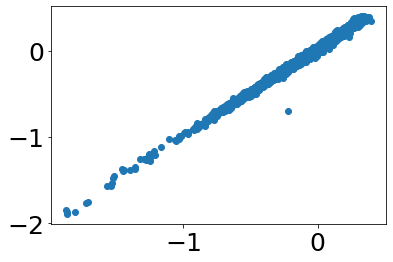

In [5]:
from astropy.io import ascii

kasc672 = fits.getdata('/Users/joshuapovick/Desktop/Research/APOKASC/APOKASC_cat_v6.7.2.fits.gz')
kasc3 = ascii.read('MLtesterr3bDR16A3PalphaM_july5.out')
dr17 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStar-dr17-synspec.fits.gz')

# xmatch APOKASC Catalogs
_, k672idx, k3idx = np.intersect1d(kasc672['2MASS_ID'],kasc3['2MASSID'],return_indices=True)
k672 = kasc672[k672idx]
k3 = kasc3[k3idx]

_, _, k3idx2 = np.intersect1d(kasc672['2MASS_ID'],kasc3['2MASSID'],return_indices=True)

# xmatch APOKASC with DR17
_, k3idx, dr17idx = np.intersect1d(k3['2MASSID'],dr17['APOGEE_ID'],return_indices=True)

k672dr17 = k672[k3idx]
k3dr17 = k3[k3idx]
kdr17 = dr17[dr17idx]

# Select RGB stars
ageevs = np.where((k3dr17['IntAge']>-10.)&(k672dr17['APOKASC3_CONS_EVSTATES']==1.0)&
                  (kdr17['GAIAEDR3_PARALLAX']/kdr17['GAIAEDR3_PARALLAX_ERROR']>3.0))

k672dr17 = k672dr17[ageevs]
k3dr17 = k3dr17[ageevs]
kdr17 = kdr17[ageevs]

apoafe = kdr17['ALPHA_M']+kdr17['M_H']-kdr17['FE_H']
apoafe_err = np.sqrt(kdr17['ALPHA_M']**2+kdr17['M_H']**2-kdr17['FE_H']**2)

plt.scatter(kdr17['FE_H'],k3dr17['Fe/H'])

In [7]:
from scipy.stats import binned_statistic
gaiaedr3 = fits.getdata('/Users/joshuapovick/Desktop/Research/gaia/GAIAEDR3allStar.fits.gz')

In [8]:
binnum = 75

### BP
bp_fin = np.where(np.isfinite(gaiaedr3['phot_bp_mean_mag'])==True)

bpmin = min(gaiaedr3['phot_bp_mean_mag'][bp_fin])
bpmax = max(gaiaedr3['phot_bp_mean_mag'][bp_fin])

bpdiff = bpmax-bpmin
bpfluxerr = (2.5*0.434)/gaiaedr3['phot_bp_mean_flux_over_error'][bp_fin]
bpmagerr = np.sqrt((bpfluxerr)**2+0.0027901700**2)

bpbin ,_,_ = binned_statistic(gaiaedr3['phot_bp_mean_mag'][bp_fin],np.log10(bpmagerr),'median',bins=binnum)

### RP 
rp_fin = np.where(np.isfinite(gaiaedr3['phot_rp_mean_mag'])==True)

rpmin = min(gaiaedr3['phot_rp_mean_mag'][rp_fin])
rpmax = max(gaiaedr3['phot_rp_mean_mag'][rp_fin])

rpdiff = rpmax-rpmin
rpfluxerr = (2.5*0.434)/gaiaedr3['phot_rp_mean_flux_over_error'][rp_fin]
rpmagerr = np.sqrt((rpfluxerr)**2+0.0037793818**2)

rpbin ,_,_ = binned_statistic(gaiaedr3['phot_rp_mean_mag'][rp_fin],np.log10(rpmagerr),'median',bins=binnum)

bperrfunc = IUS(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin)
rperrfunc = IUS(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin)

bperr = 10**bperrfunc(kdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'])
rperr = 10**rperrfunc(kdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'])

# Calculate Extinction

In [9]:
from tqdm import tqdm_notebook

In [10]:
kasc_ak = 999999.0*np.ones(len(np.squeeze(ageevs)))
kasc_ak_err = 999999.0*np.ones(len(np.squeeze(ageevs)))

apoafe = kdr17['ALPHA_M']+kdr17['M_H']-kdr17['FE_H']
apoafe_err = np.sqrt(kdr17['ALPHA_M']**2+kdr17['M_H']**2-kdr17['FE_H']**2)

for i in tqdm_notebook(range(len(np.squeeze(ageevs)))):
    te = np.array([kdr17['TEFF'][i],kdr17['TEFF_ERR'][i]])
    ab = np.array([[kdr17['FE_H'][i],apoafe[i]],
                   [kdr17['FE_H_ERR'][i],apoafe_err[i]]]).T
    op = np.array([[kdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'][i],
                    kdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'][i],
                    kdr17['J'][i],kdr17['H'][i],
                    kdr17['K'][i]],
                   [bperr[i],rperr[i],kdr17['J_ERR'][i],
                    kdr17['H_ERR'][i],kdr17['K_ERR'][i]]]).T
    di = (1/kdr17['GAIAEDR3_PARALLAX'][i])*1000

    CalcAge = Aetas(te,ab,op,di,massive,rv=3.1)
    ak = CalcAge.extinction()
    kasc_ak[i] = ak[0]
    kasc_ak_err[i] = ak[1]

<ipython-input-10-6e1aff655bde>:5: RuntimeWarning: invalid value encountered in sqrt
  apoafe_err = np.sqrt(kdr17['ALPHA_M']**2+kdr17['M_H']**2-kdr17['FE_H']**2)
<ipython-input-10-6e1aff655bde>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(np.squeeze(ageevs)))):


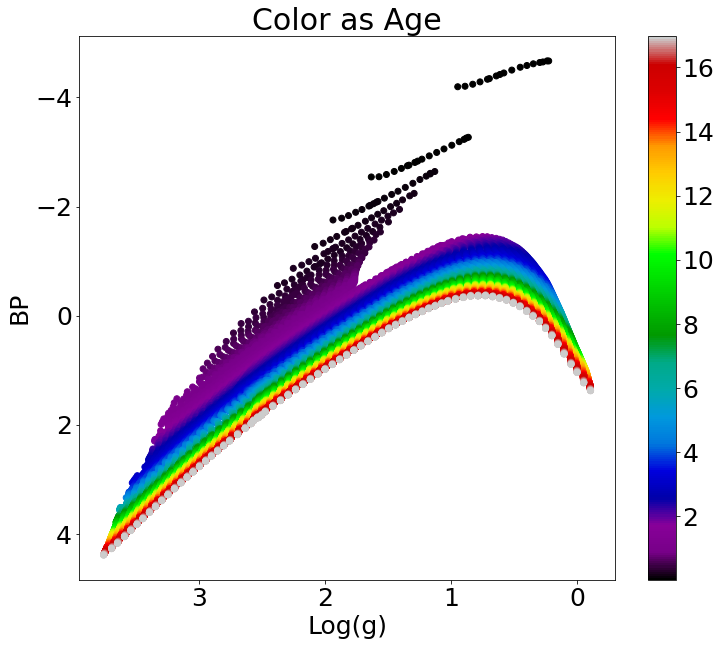

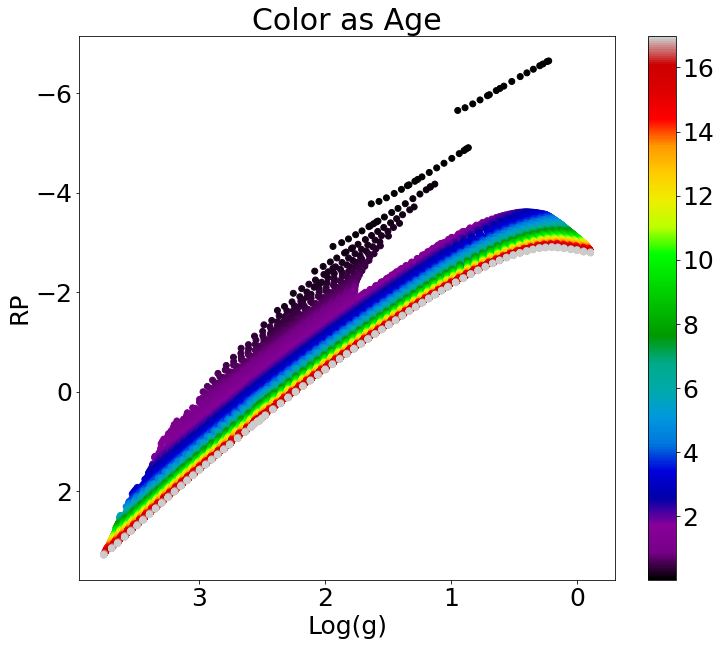

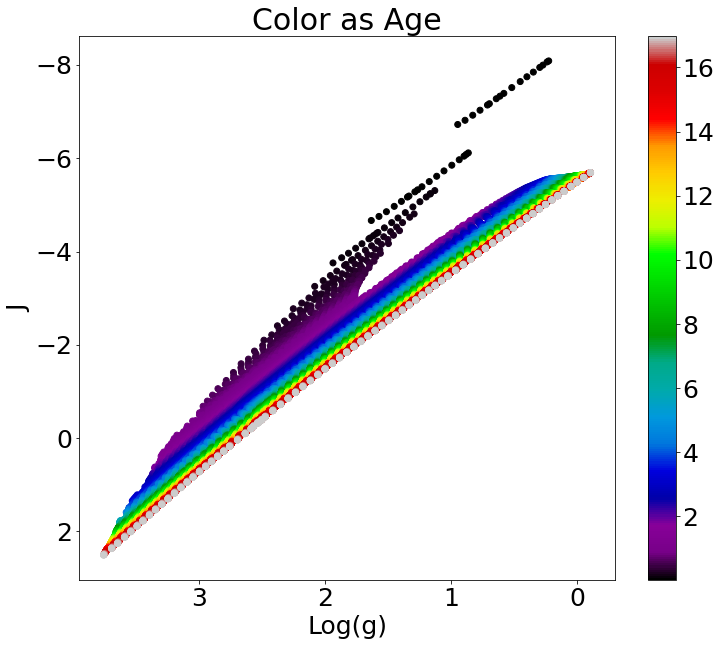

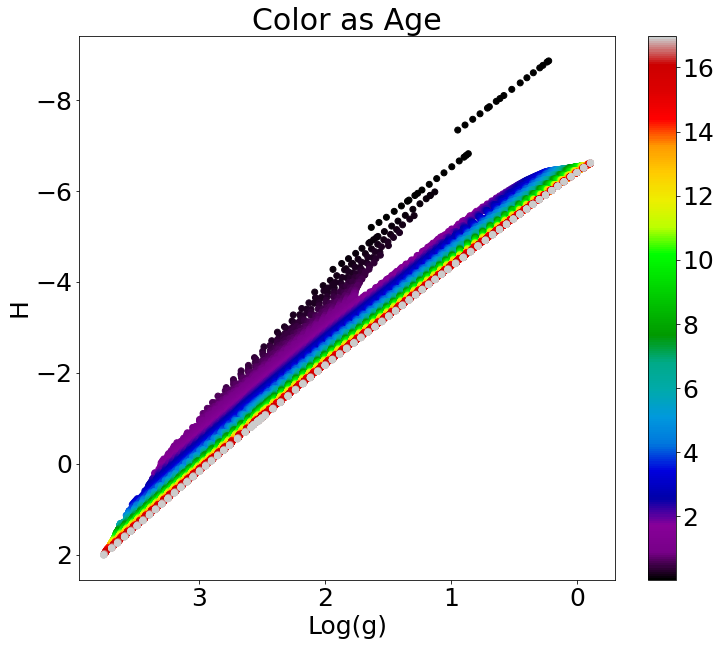

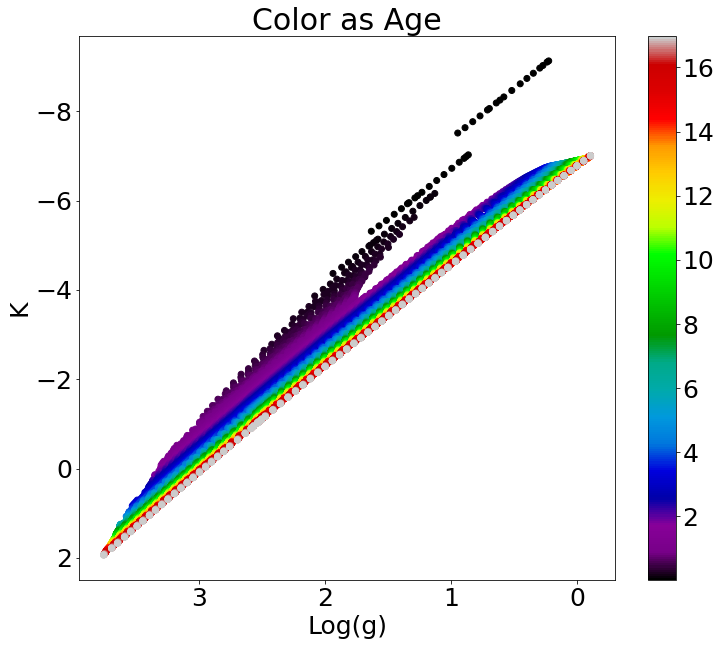

In [20]:
test = np.where(massive['MH']==closest(massive['MH'],-0.15))

plt.figure(figsize=[12,10])
plt.scatter(massive['logg'][test],massive['G_BPmag'][test],c=10**massive['logAge'][test]/10**9,cmap='nipy_spectral')
plt.colorbar()
plt.title(r'Color as Age')
plt.xlabel(r'Log(g)')
plt.ylabel(r'BP')

plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

plt.show()

plt.figure(figsize=[12,10])
plt.scatter(massive['logg'][test],massive['G_RPmag'][test],c=10**massive['logAge'][test]/10**9,cmap='nipy_spectral')
plt.colorbar()
plt.title(r'Color as Age')
plt.xlabel(r'Log(g)')
plt.ylabel(r'RP')

plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

plt.show()

plt.figure(figsize=[12,10])
plt.scatter(massive['logg'][test],massive['Jmag'][test],c=10**massive['logAge'][test]/10**9,cmap='nipy_spectral')
plt.colorbar()
plt.title(r'Color as Age')
plt.xlabel(r'Log(g)')
plt.ylabel(r'J')

plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

plt.show()

plt.figure(figsize=[12,10])
plt.scatter(massive['logg'][test],massive['Hmag'][test],c=10**massive['logAge'][test]/10**9,cmap='nipy_spectral')
plt.colorbar()
plt.title(r'Color as Age')
plt.xlabel(r'Log(g)')
plt.ylabel(r'H')

plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

plt.show()

plt.figure(figsize=[12,10])
plt.scatter(massive['logg'][test],massive['Ksmag'][test],c=10**massive['logAge'][test]/10**9,cmap='nipy_spectral')
plt.colorbar()
plt.title(r'Color as Age')
plt.xlabel(r'Log(g)')
plt.ylabel(r'K')

plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

plt.show()

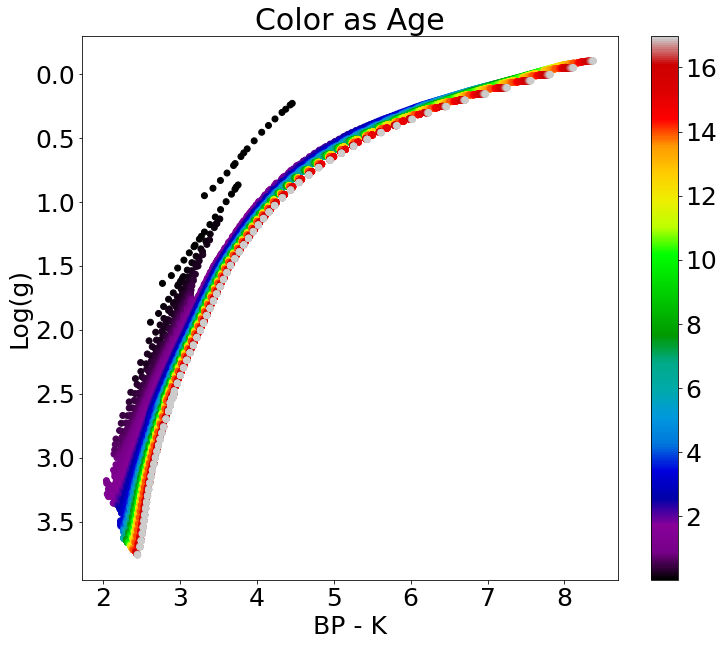

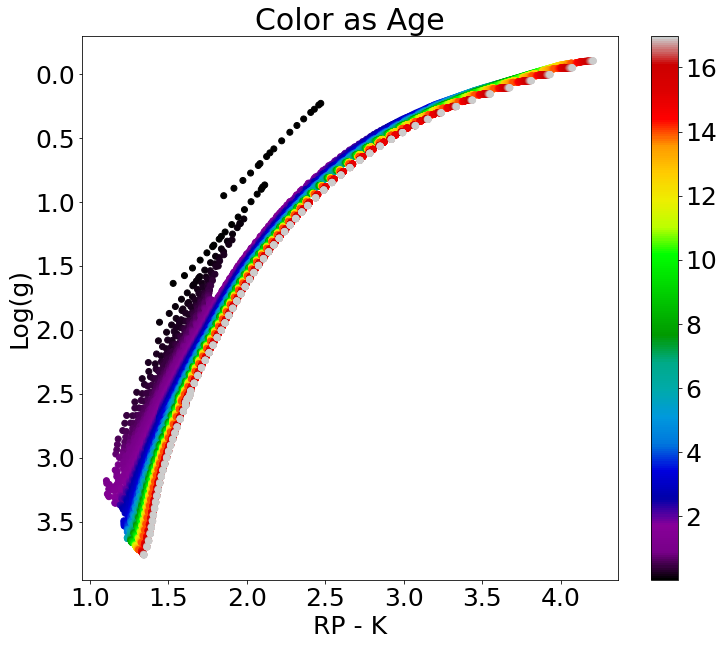

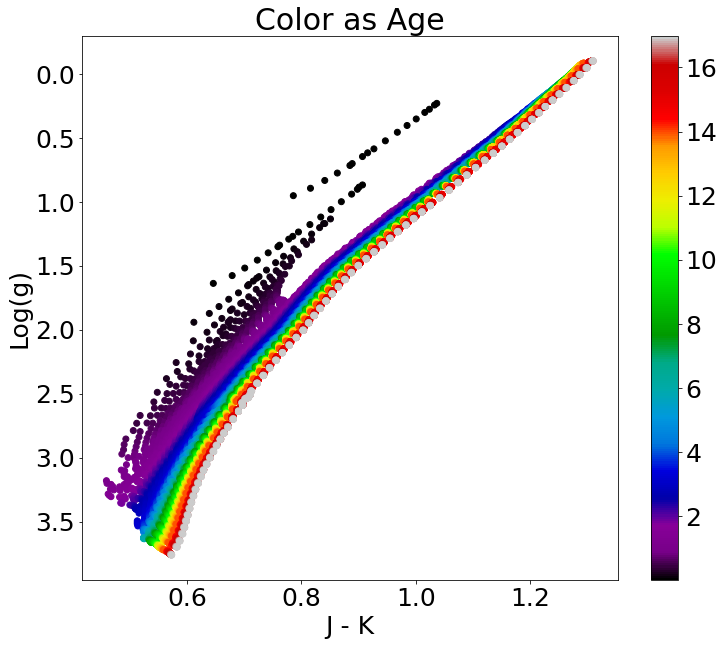

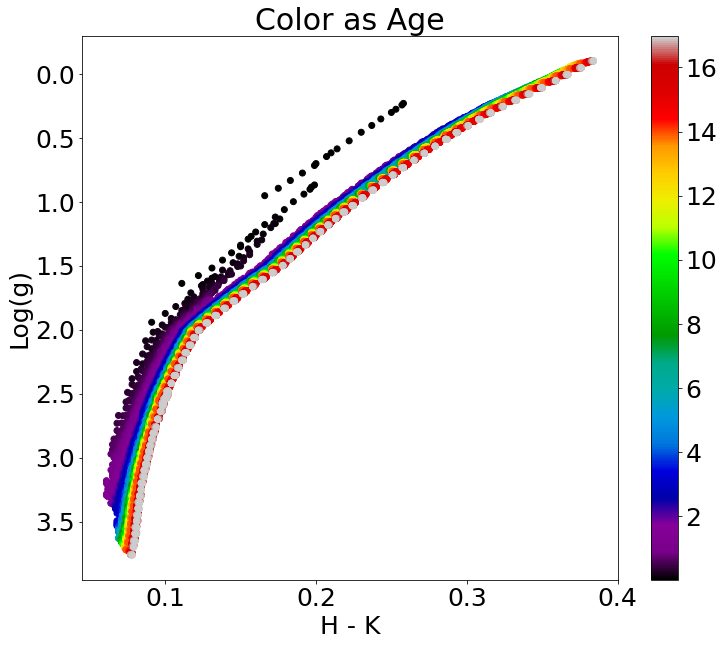

In [25]:
plt.figure(figsize=[12,10])
plt.scatter((massive['G_BPmag']-massive['Ksmag'])[test],massive['logg'][test],
            c=10**massive['logAge'][test]/10**9,cmap='nipy_spectral')
plt.colorbar()

plt.gca().invert_yaxis()

plt.title(r'Color as Age')
plt.xlabel(r'BP - K')
plt.ylabel(r'Log(g)')
plt.show()

plt.figure(figsize=[12,10])
plt.scatter((massive['G_RPmag']-massive['Ksmag'])[test],massive['logg'][test],
            c=10**massive['logAge'][test]/10**9,cmap='nipy_spectral')
plt.colorbar()

plt.gca().invert_yaxis()

plt.title(r'Color as Age')
plt.xlabel(r'RP - K')
plt.ylabel(r'Log(g)')
plt.show()

plt.figure(figsize=[12,10])
plt.scatter((massive['Jmag']-massive['Ksmag'])[test],massive['logg'][test],
            c=10**massive['logAge'][test]/10**9,cmap='nipy_spectral')
plt.colorbar()

plt.gca().invert_yaxis()

plt.title(r'Color as Age')
plt.xlabel(r'J - K')
plt.ylabel(r'Log(g)')
plt.show()

plt.figure(figsize=[12,10])
plt.scatter((massive['Hmag']-massive['Ksmag'])[test],massive['logg'][test],
            c=10**massive['logAge'][test]/10**9,cmap='nipy_spectral')
plt.colorbar()

plt.gca().invert_yaxis()

plt.title(r'Color as Age')
plt.xlabel(r'H - K')
plt.ylabel(r'Log(g)')
plt.show()

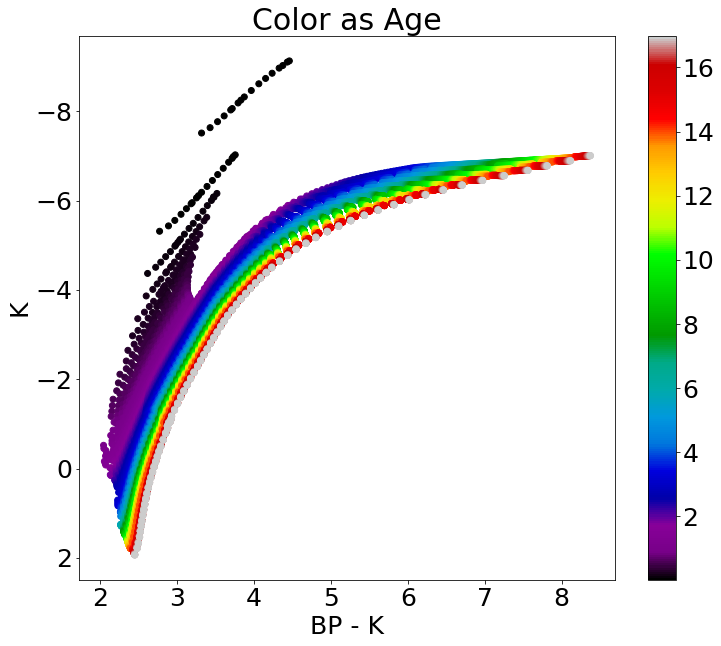

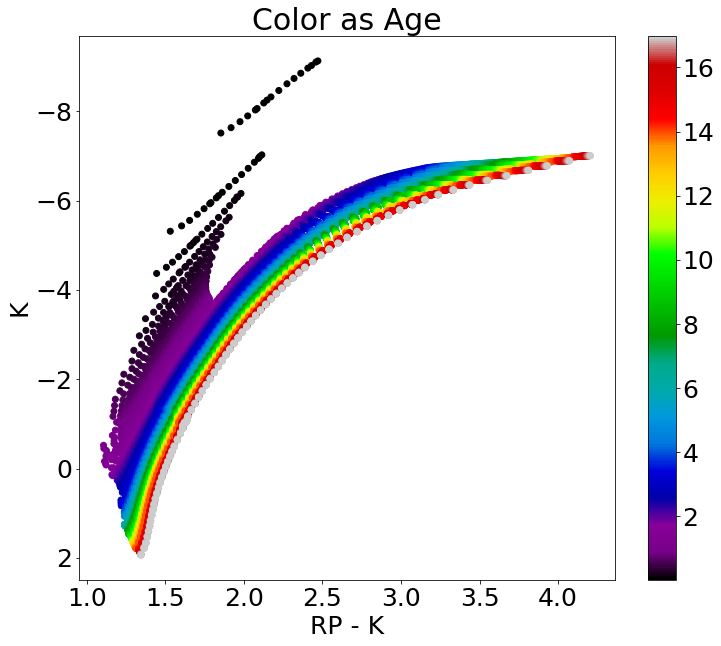

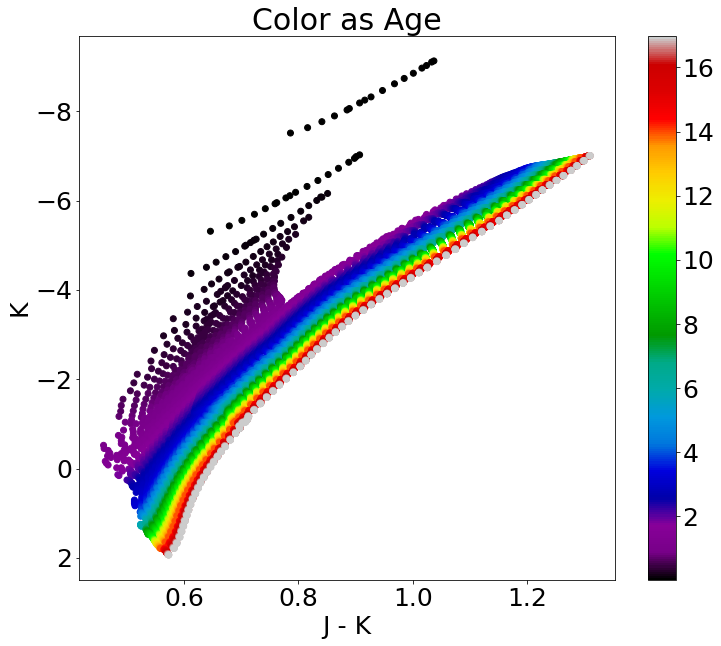

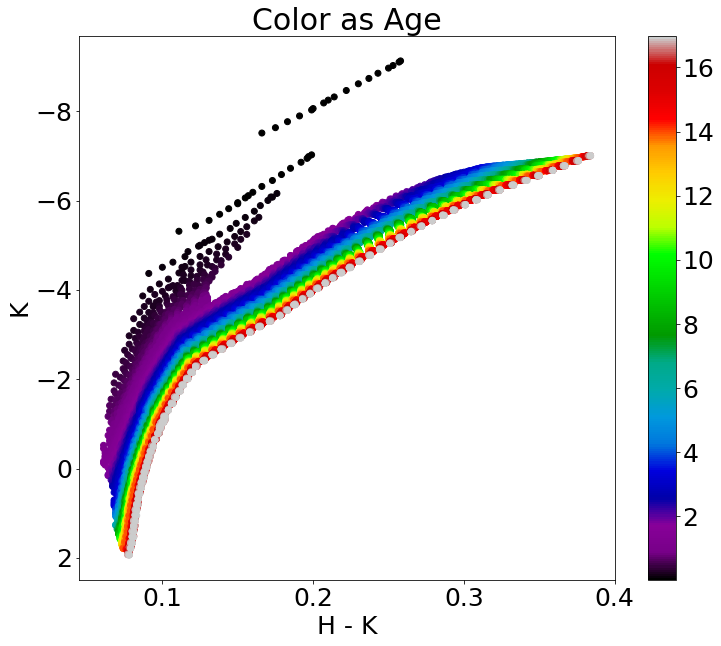

In [26]:
plt.figure(figsize=[12,10])
plt.scatter((massive['G_BPmag']-massive['Ksmag'])[test],massive['Ksmag'][test],
            c=10**massive['logAge'][test]/10**9,cmap='nipy_spectral')
plt.colorbar()

plt.gca().invert_yaxis()

plt.title(r'Color as Age')
plt.xlabel(r'BP - K')
plt.ylabel(r'K')
plt.show()

plt.figure(figsize=[12,10])
plt.scatter((massive['G_RPmag']-massive['Ksmag'])[test],massive['Ksmag'][test],
            c=10**massive['logAge'][test]/10**9,cmap='nipy_spectral')
plt.colorbar()

plt.gca().invert_yaxis()

plt.title(r'Color as Age')
plt.xlabel(r'RP - K')
plt.ylabel(r'K')
plt.show()

plt.figure(figsize=[12,10])
plt.scatter((massive['Jmag']-massive['Ksmag'])[test],massive['Ksmag'][test],
            c=10**massive['logAge'][test]/10**9,cmap='nipy_spectral')
plt.colorbar()

plt.gca().invert_yaxis()

plt.title(r'Color as Age')
plt.xlabel(r'J - K')
plt.ylabel(r'K')
plt.show()

plt.figure(figsize=[12,10])
plt.scatter((massive['Hmag']-massive['Ksmag'])[test],massive['Ksmag'][test],
            c=10**massive['logAge'][test]/10**9,cmap='nipy_spectral')
plt.colorbar()

plt.gca().invert_yaxis()

plt.title(r'Color as Age')
plt.xlabel(r'H - K')
plt.ylabel(r'K')
plt.show()

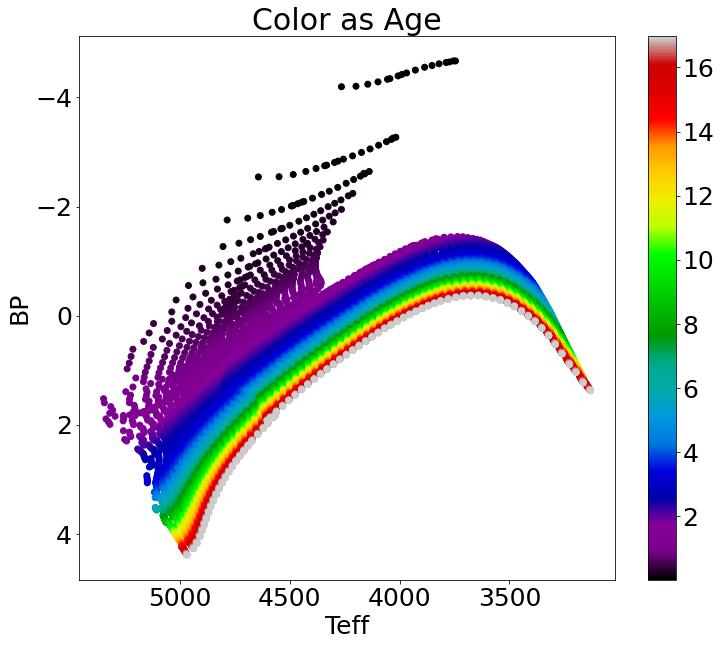

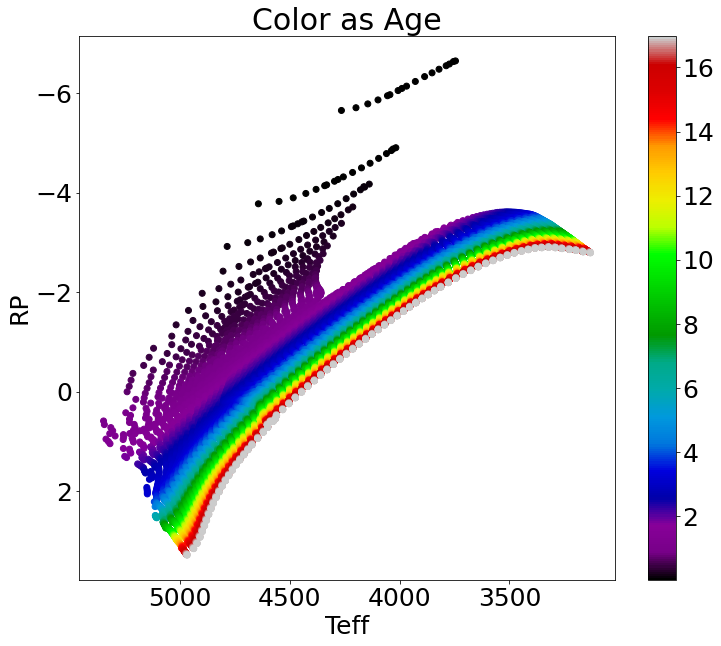

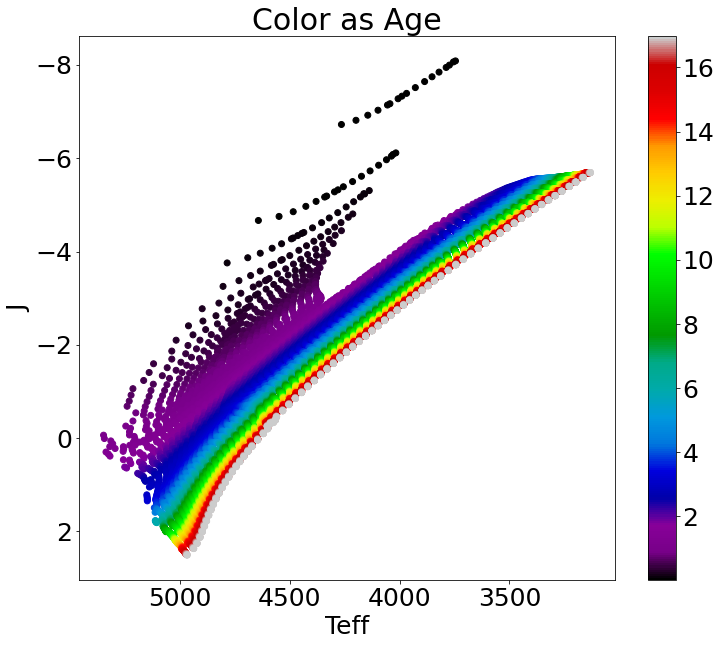

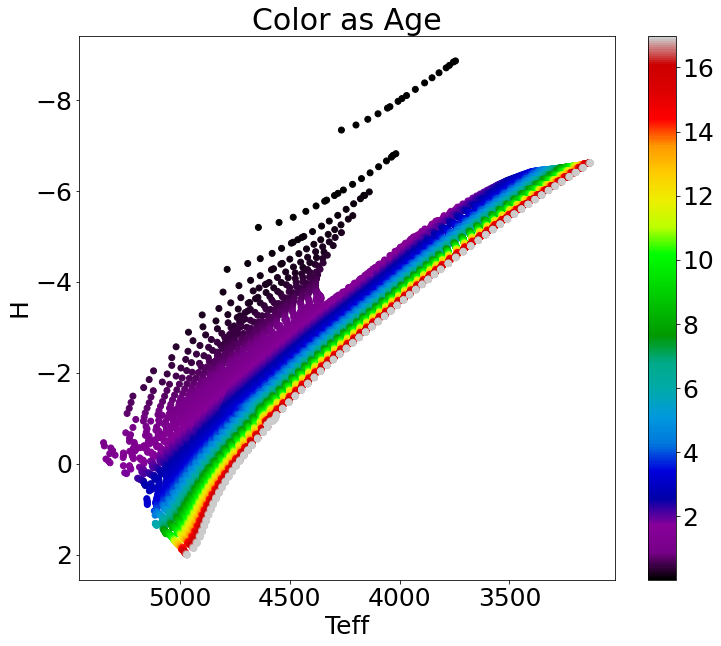

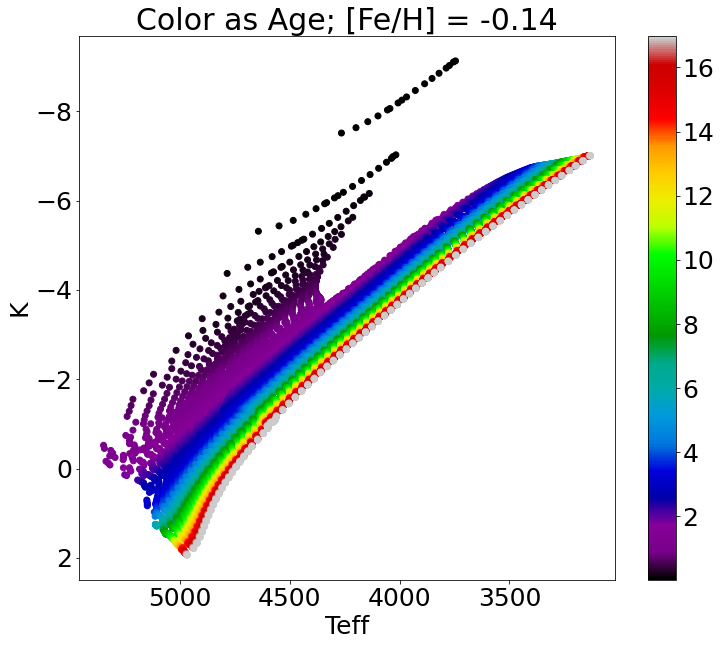

In [46]:
plt.figure(figsize=[12,10])
plt.scatter(10**massive['logTe'][test],massive['G_BPmag'][test],
            c=10**massive['logAge'][test]/10**9,cmap='nipy_spectral')
plt.colorbar()
plt.title(r'Color as Age')
plt.xlabel(r'Teff')
plt.ylabel(r'BP')

plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

plt.show()

plt.figure(figsize=[12,10])
plt.scatter(10**massive['logTe'][test],massive['G_RPmag'][test],
            c=10**massive['logAge'][test]/10**9,cmap='nipy_spectral')
plt.colorbar()
plt.title(r'Color as Age')
plt.xlabel(r'Teff')
plt.ylabel(r'RP')

plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

plt.show()

plt.figure(figsize=[12,10])
plt.scatter(10**massive['logTe'][test],massive['Jmag'][test],
            c=10**massive['logAge'][test]/10**9,cmap='nipy_spectral')
plt.colorbar()
plt.title(r'Color as Age')
plt.xlabel(r'Teff')
plt.ylabel(r'J')

plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

plt.show()

plt.figure(figsize=[12,10])
plt.scatter(10**massive['logTe'][test],massive['Hmag'][test],
            c=10**massive['logAge'][test]/10**9,cmap='nipy_spectral')
plt.colorbar()
plt.title(r'Color as Age')
plt.xlabel(r'Teff')
plt.ylabel(r'H')

plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

plt.show()

plt.figure(figsize=[12,10])
plt.scatter(10**massive['logTe'][test],massive['Ksmag'][test],
            c=10**massive['logAge'][test]/10**9,cmap='nipy_spectral')
plt.colorbar()
plt.title(r'Color as Age; [Fe/H] = -0.14')
plt.xlabel(r'Teff')
plt.ylabel(r'K')

plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

plt.savefig('../plots/k_teff_iso.pdf',dpi=300,bbox_inches='tight')

plt.show()

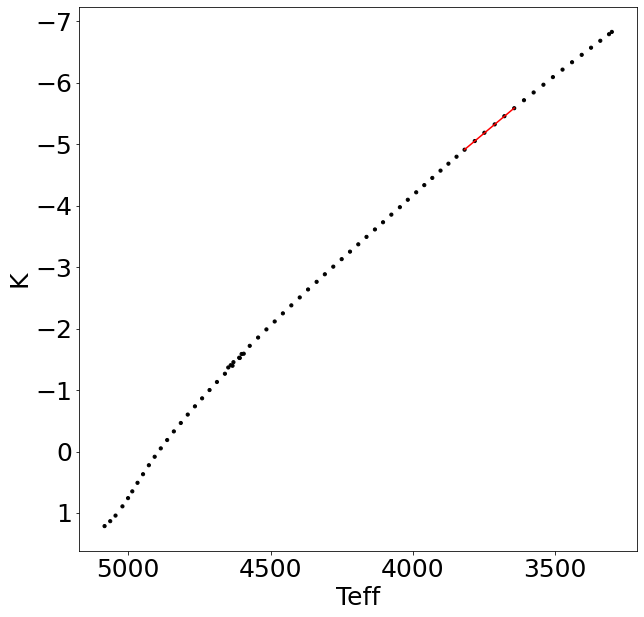

In [41]:
f_014a6 = np.where((massive['MH']==-0.14)&(massive['logAge']==closest(massive['logAge'],np.log10(6*10**9))))

teff_test = 3733.0

teffcut = np.where((massive['logTe'][f_014a6]<np.log10(teff_test+100.))&
                   (massive['logTe'][f_014a6]>np.log10(teff_test-100.)))

# iso_ = self.iso[teffcut]

# # sort teffs
sidx = np.argsort(massive['logTe'][f_014a6][teffcut])
slogTe = massive['logTe'][f_014a6][teffcut][sidx]
_, uidx = np.unique(slogTe,return_index=True)
slogTe = slogTe[uidx]
sK = massive['Ksmag'][f_014a6][teffcut][sidx][uidx]

spl = np.poly1d(np.polyfit(10**slogTe,sK,1))

plt.figure(figsize=[10,10])
plt.scatter(10**massive['logTe'][f_014a6],massive['Ksmag'][f_014a6],
            c=10**massive['logAge'][f_014a6]/10**9,cmap='nipy_spectral',s=10)

xs = np.linspace(min(10**massive['logTe'][f_014a6][teffcut]),max(10**massive['logTe'][f_014a6][teffcut]))
plt.plot(xs,spl(xs),c='r')

# plt.colorbar()
# plt.title(r'Color as Age')
plt.xlabel(r'Teff')
plt.ylabel(r'K')

plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

plt.show()

In [ ]:
def teff_2_absmag(teff,salfeh,age,isochrones):
    '''
    Calculate the magnitude of a star given its teff, metallicity and age
    '''
    teff = obsteff[0]
    teff_err = obsteff[1]
    
    phot = obsphot[:,0]
    phot_err = obsphot[:,1]
    
    lgage = np.log10(age)
    
    uniq_ages = np.unique(isochrones['logAge'])
    
    labels = np.array(['G_BPmag','G_RPmag','Jmag','Hmag','Ksmag'])

    singfeh = np.where(isochrones['MH']==closest(isochrones['MH'],salfeh))
    
    #check teff
    
#     teffcut = np.where((isochrones['logTe'][singfeh]<np.log10(teff+100.))&
#                        (isochrones['logTe'][singfeh]>np.log10(teff-100.)))
#     iso_ = isochrones[singfeh][teffcut]
    
#     if lgage in uniq_ages:
            
        ### pick out a single isochrone 
#         aidx, = np.where(self.uniq_ages==lgage)
#         iso_ = self.iso[self.age_idx[int(aidx)][0]:self.age_idx[int(aidx)][1]]
#         age

    lgage_lo,lgage_hi = neighbors(uniq_ages,lgage)
        
    
    

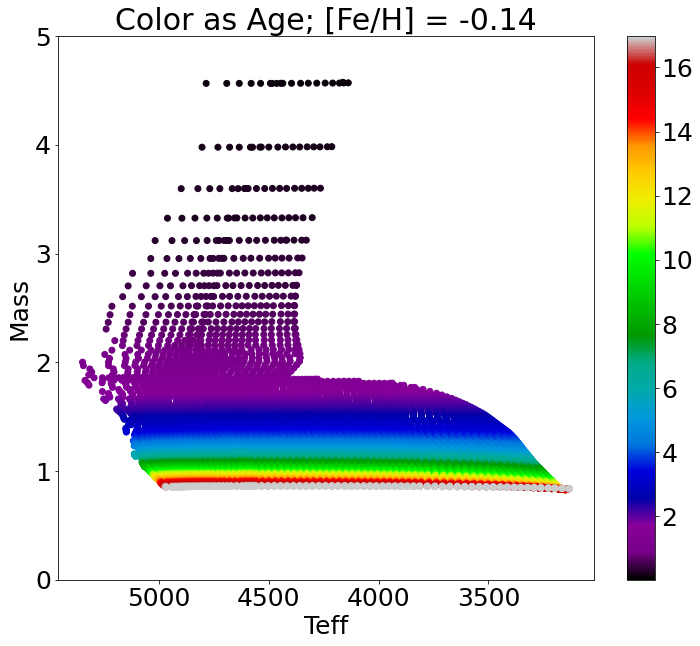

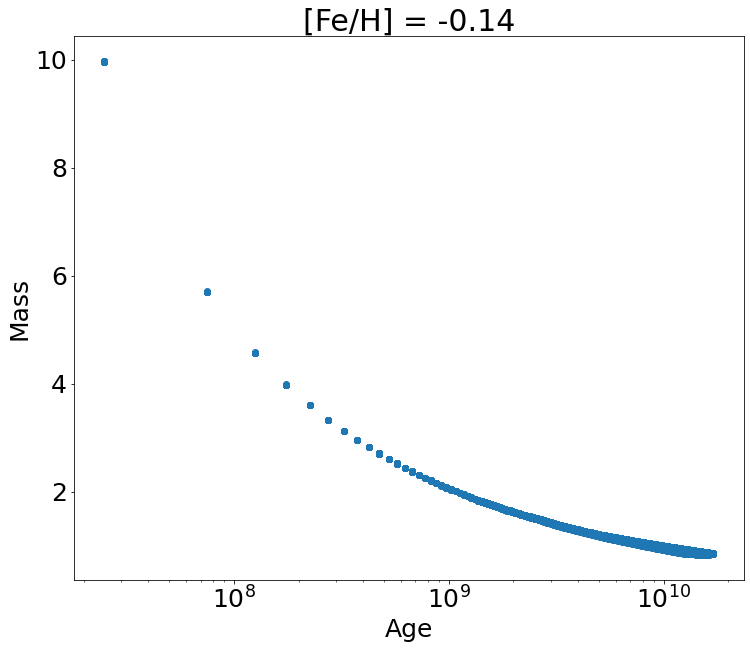

In [55]:
plt.figure(figsize=[12,10])
plt.scatter(10**massive['logTe'][test],massive['Mass'][test],
            c=10**massive['logAge'][test]/10**9,cmap='nipy_spectral')
plt.colorbar()
plt.title(r'Color as Age; [Fe/H] = -0.14')
plt.xlabel(r'Teff')
plt.ylabel(r'Mass')

plt.ylim(0,5)

# plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

# plt.savefig('../plots/k_teff_iso.pdf',dpi=300,bbox_inches='tight')

plt.show()

#####
plt.figure(figsize=[12,10])
plt.scatter(10**massive['logAge'][test],massive['Mass'][test]),
#             c=10**massive['logTe'][test],cmap='nipy_spectral')
# plt.colorbar()
plt.xscale('log')
plt.title(r'[Fe/H] = -0.14')
plt.xlabel(r'Age')
plt.ylabel(r'Mass')

# plt.ylim(0,5)

# plt.gca().invert_yaxis()
# plt.gca().invert_xaxis()

# plt.savefig('../plots/k_teff_iso.pdf',dpi=300,bbox_inches='tight')

plt.show()

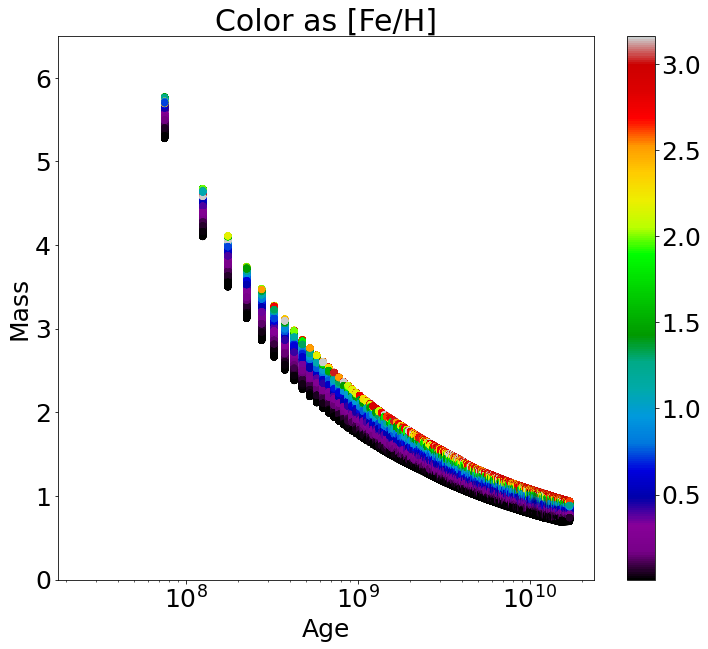

In [77]:
#####
plt.figure(figsize=[12,10])
plt.scatter(10**massive['logAge'],massive['Mass'],c=10**massive['MH'],cmap='nipy_spectral')
plt.colorbar()
plt.xscale('log')
plt.title(r'Color as [Fe/H]')
plt.xlabel(r'Age')
plt.ylabel(r'Mass')

plt.ylim(0,6.5)

# plt.gca().invert_yaxis()
# plt.gca().invert_xaxis()

# plt.savefig('../plots/age_mass_iso.pdf',dpi=300,bbox_inches='tight')

plt.show()

In [83]:
massive_curtfeh = massive[np.where((massive['MH']==closest(massive['MH'],-2.1))|
                                   (massive['MH']==closest(massive['MH'],-1.8))|
                                   (massive['MH']==closest(massive['MH'],-1.5))|
                                   (massive['MH']==closest(massive['MH'],-1.2))|
                                   (massive['MH']==closest(massive['MH'],-0.9))|
                                   (massive['MH']==closest(massive['MH'],-0.6))|
                                   (massive['MH']==closest(massive['MH'],-0.3))|
                                   (massive['MH']==closest(massive['MH'],0.0))|
                                   (massive['MH']==closest(massive['MH'],0.3)))]

[-2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3]


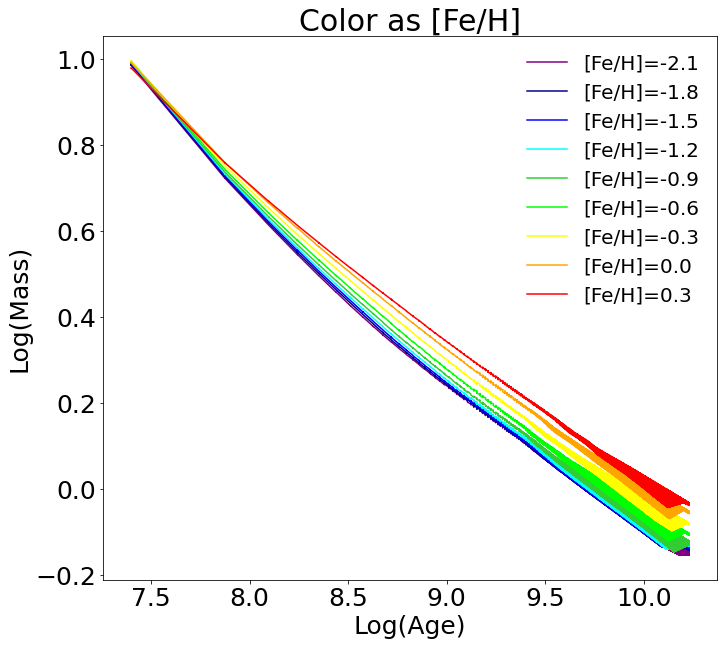

In [102]:
fehcolors = np.array(['purple','darkblue','blue','cyan','limegreen','lime','yellow','orange','red'])

mfehs = np.array([closest(massive['MH'],-2.1),closest(massive['MH'],-1.8),closest(massive['MH'],-1.5),
                  closest(massive['MH'],-1.2),closest(massive['MH'],-0.9),closest(massive['MH'],-0.6),
                  closest(massive['MH'],-0.3),closest(massive['MH'],0.0),closest(massive['MH'],0.3)])

#####
plt.figure(figsize=[11,10])
for i in range(len(mfehs)):
    smfeh = np.where(massive_curtfeh['MH']==mfehs[i]) 
    plt.plot(massive_curtfeh['logAge'][smfeh],np.log10(massive_curtfeh['Mass'][smfeh]),c=fehcolors[i],
                label='[Fe/H]={}'.format(mfehs[i]))
plt.legend(prop={'size': 20},frameon=False)
# plt.xscale('log')
# plt.yscale('log')
plt.title(r'Color as [Fe/H]')
plt.xlabel(r'Log(Age)')
plt.ylabel(r'Log(Mass)')

# plt.ylim(0,10.)

plt.savefig('../plots/age_mass_iso.pdf',dpi=300,bbox_inches='tight')

plt.show()

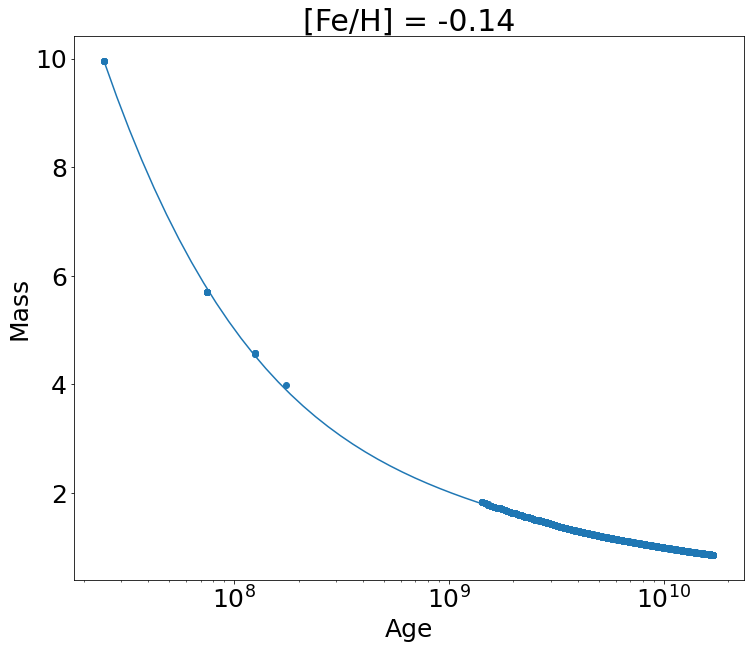

In [62]:
tefftest = np.where((massive['logTe'][test]>np.log10(4123-100))&(massive['logTe'][test]<np.log10(4123+100)))

#####
plt.figure(figsize=[12,10])
plt.scatter(10**massive['logAge'][test][tefftest],massive['Mass'][test][tefftest])
interpol = np.poly1d(np.polyfit(massive['logAge'][test][tefftest],massive['Mass'][test][tefftest],4))

xs = np.linspace(min(massive['logAge'][test][tefftest]),max(massive['logAge'][test][tefftest]))
plt.plot(10**xs,interpol(xs))

plt.xscale('log')
plt.title(r'[Fe/H] = -0.14')
plt.xlabel(r'Age')
plt.ylabel(r'Mass')

plt.show()

In [ ]:
    def get_mass(self):
        '''
        Calculate the mass of a star by interpolating isochrones with already calculated Ak and age 

        Output:
        ------
        mass: mass of star in solar masses
        mass_err: error in the calculated mass of the star
        '''

        if self.age == 999999.0:
            return 999999.0 #np.array([999999.0,999999.0])
        
        teffcut = np.where((self.iso['logTe']<np.log10(self.teff+100.))&
                           (self.iso['logTe']>np.log10(self.teff-100.)))
        iso_ = self.iso[teffcut]
        
        if np.size(iso_) < 2:
            return 999999.0
        
        ### calculate the mass using interpolation
        coeffs = np.polyfit(iso_['logAge'],iso_['Mass'],4)
        interpol = np.poly1d(coeffs)
        mass = interpol(np.log10(self.age*10**9))
        self.mass = mass
        
        ### get error in mass calculation
#         deriv = np.poly1d(np.multiply(coeffs[:-1],np.arange(len(coeffs))[::-1][:-1]))
#         mass_err = np.abs(deriv(np.log10(self.age*10**9)))*self.age_err
#         self.mass_err = mass_err
        
        return mass#, mass_err

In [73]:
coeffs = np.array([3,2,1])

deriv = np.multiply(coeffs[:-1],np.arange(len(coeffs))[::-1][:-1])
p = np.poly1d(deriv)
print(p)

 
6 x + 2


In [67]:
np.arange(3)[::-1][:-1]

array([2, 1])

In [106]:
massive_curtage = massive[np.where((massive['logAge']==closest(massive['logAge'],1.0))|
                                   (massive['logAge']==closest(massive['logAge'],2.0))|
                                   (massive['logAge']==closest(massive['logAge'],3.0))|
                                   (massive['logAge']==closest(massive['logAge'],4.0))|
                                   (massive['logAge']==closest(massive['logAge'],5.0))|
                                   (massive['logAge']==closest(massive['logAge'],6.0))|
                                   (massive['logAge']==closest(massive['logAge'],7.0))|
                                   (massive['logAge']==closest(massive['logAge'],8.0))|
                                   (massive['logAge']==closest(massive['logAge'],9.0))|
                                   (massive['logAge']==closest(massive['logAge'],10.0))|
                                   (massive['logAge']==closest(massive['logAge'],11.0))|
                                   (massive['logAge']==closest(massive['logAge'],12.0))|
                                   (massive['logAge']==closest(massive['logAge'],13.0))|
                                   (massive['logAge']==closest(massive['logAge'],14.0))|
                                   (massive['logAge']==closest(massive['logAge'],15.0))|
                                   (massive['logAge']==closest(massive['logAge'],16.0))|
                                   (massive['logAge']==closest(massive['logAge'],17.0)))]

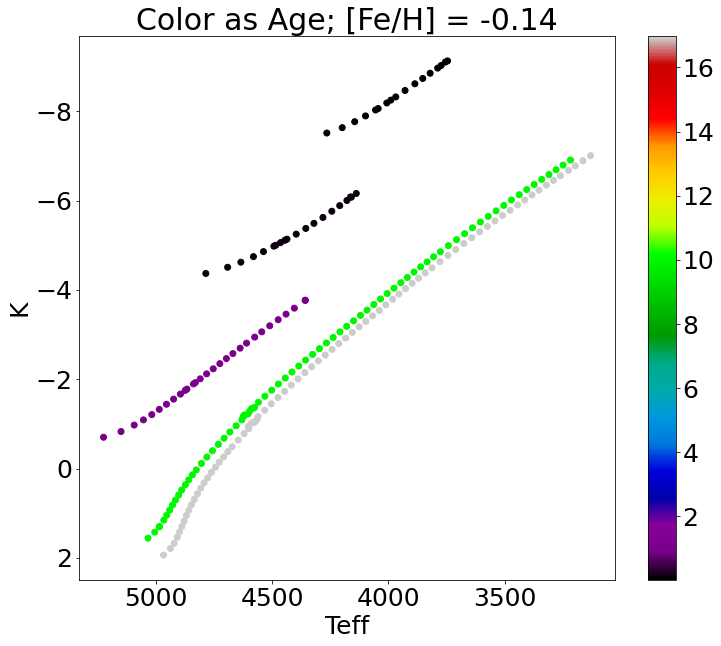

In [107]:
curtage_014 = np.where(massive_curtage['MH']==-0.14) 

plt.figure(figsize=[12,10])
plt.scatter(10**massive_curtage['logTe'][curtage_014],massive_curtage['Ksmag'][curtage_014],
            c=10**massive_curtage['logAge'][curtage_014]/10**9,cmap='nipy_spectral')
plt.colorbar()
plt.title(r'Color as Age; [Fe/H] = -0.14')
plt.xlabel(r'Teff')
plt.ylabel(r'K')

plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

# plt.savefig('../plots/k_teff_iso.pdf',dpi=300,bbox_inches='tight')

plt.show()